In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Study/DL main project

/content/drive/MyDrive/Study/DL main project


# **Import Lib**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.image import ssim
from process_data import ProcessData, DataGenerator
import os
from xray_abnormal_viewer import XABViewer
from dae_model import DAE_Model
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
def iou_score(ground_truth,predict_mask):
  intersection = np.logical_and(ground_truth, predict_mask)
  union = np.logical_or(ground_truth, predict_mask)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

# **Load Data**

In [ ]:
csv_path = './csv'
img_load_dir = './train/png'
npy_load_dir = './train/npy'
mask_load_dir = './train/mask'
lung_load_dir = './train/lung'
noise_load_dir = './train/noise'

# batch_14 = ['000','001']
batch_14 = ['{:03d}'.format(i) for i in range(21)]
# make process variable
pdata = ProcessData(seed=42)

In [ ]:
# npy_dict = {}
mask_dict = {}
img_dict = {}
lung_dict = {}
noise_dict = {}

for b in batch_14:
  batch_csv = os.path.join(csv_path,'14',b+'.csv')
  mask_load_path = os.path.join(mask_load_dir,'14',b)
  img_load_path = os.path.join(img_load_dir,'14',b)
  lung_load_path = os.path.join(lung_load_dir,'14',b)
  noise_load_path = os.path.join(noise_load_dir,'14',b)
  noise_dict[noise_load_path] = mask_dict[mask_load_path] = img_dict[img_load_path] = lung_dict[lung_load_path] = pdata.get_img_names(batch_csv)

In [ ]:
img_paths = pdata.get_paths(img_dict,'.png')
mask_paths = pdata.get_paths(mask_dict,'.png')
lung_paths = pdata.get_paths(lung_dict,'.png')
noise_paths = pdata.get_paths(noise_dict,'.png')

In [ ]:
def processor(x,y):
  noises = pdata.get_imgs(x,show_process=False)
  lungs = pdata.get_imgs(y,show_process=False)
  return noises, lungs

# **Process Data**

In [ ]:
#size = (256,256) # Nếu run model 256x256
size = None # Nếu run model 1024x1024

## **Process**

In [ ]:
# nb_np = len(noise_paths)
# noise_paths = noise_paths[:int(nb_np/2)]
# nb_lp = len(lung_paths)
# lung_paths = lung_paths[:int(nb_lp/2)]
# nb_np, nb_lp

In [ ]:
from sklearn.model_selection import train_test_split
ytrain,ytest = train_test_split(mask_paths,test_size=0.1,random_state=42)
ytrain,yval = train_test_split(ytrain,test_size=0.15,random_state=42)
ytrain.shape, yval.shape,ytest.shape

((2368,), (418,), (310,))

In [ ]:
ytrain = np.array(pdata.get_imgs(ytrain,size=size))

In [ ]:
xtrain = pdata.get_data_noise_vlazy(ytrain,ntype=1)

In [ ]:
yval = np.array(pdata.get_imgs(yval,size=size))

In [ ]:
xval = pdata.get_data_noise_vlazy(yval,ntype=1)

In [ ]:
ytest = np.array(pdata.get_imgs(ytest,size=size))

In [ ]:
xtest = pdata.get_data_noise_vlazy(ytest,ntype=1)

## Model latent is d256 sigmoid

In [ ]:
args = {
    'filters' : (32,32,32,32,32),
    'latentDim' : 256,
    'model_name' : 'mask_d256_f32x5_ep100_sigmoid',
    'model_dir':'./model',
    'activation_all': False
}
model = DAE_Model(input_shape=(1024,1024,1),**args)

(256,)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_mask_d256_f32x5_ep100_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_mask_d256_f32x5_ep10 (None, 256)               8426816   
_________________________________________________________________
decoder_mask_d256_f32x5_ep10 (None, 1024, 1024, 1)     8468545   
Total params: 16,895,361
Trainable params: 16,894,721
Non-trainable params: 640
_________________________________________________________________


In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 50
bs = 5

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*5)
model.decay_steps

2365

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/50
473/473 [==============================] - 137s 271ms/step - loss: 0.0632 - lr: 9.9795e-04 - val_loss: 0.0441 - val_lr: 9.9187e-04

Epoch 00001: val_loss improved from inf to 0.04405, saving model to ./model/checkpoint/autoencoder_mask_d256_f32x5_ep100_sigmoid/autoencoder_mask_d256_f32x5_ep100_sigmoid-0001-0.0441.h5
Epoch 2/50
473/473 [==============================] - 139s 294ms/step - loss: 0.0259 - lr: 9.8983e-04 - val_loss: 0.0320 - val_lr: 9.8380e-04

Epoch 00002: val_loss improved from 0.04405 to 0.03205, saving model to ./model/checkpoint/autoencoder_mask_d256_f32x5_ep100_sigmoid/autoencoder_mask_d256_f32x5_ep100_sigmoid-0002-0.0320.h5
Epoch 3/50
473/473 [==============================] - 140s 297ms/step - loss: 0.0207 - lr: 9.8178e-04 - val_loss: 0.0243 - val_lr: 9.7580e-04

Epoch 00003: val_loss improved from 0.03205 to 0.02428, saving model to ./model/checkpoint/autoencoder_mask_d256_f32x5_ep100_sigmoid/autoencoder_mask_d256_f32x5_ep100_sigmoid-0003-0.0243.h5
Epoch

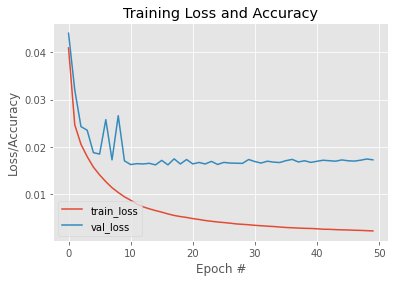

In [ ]:
model.plot_show()

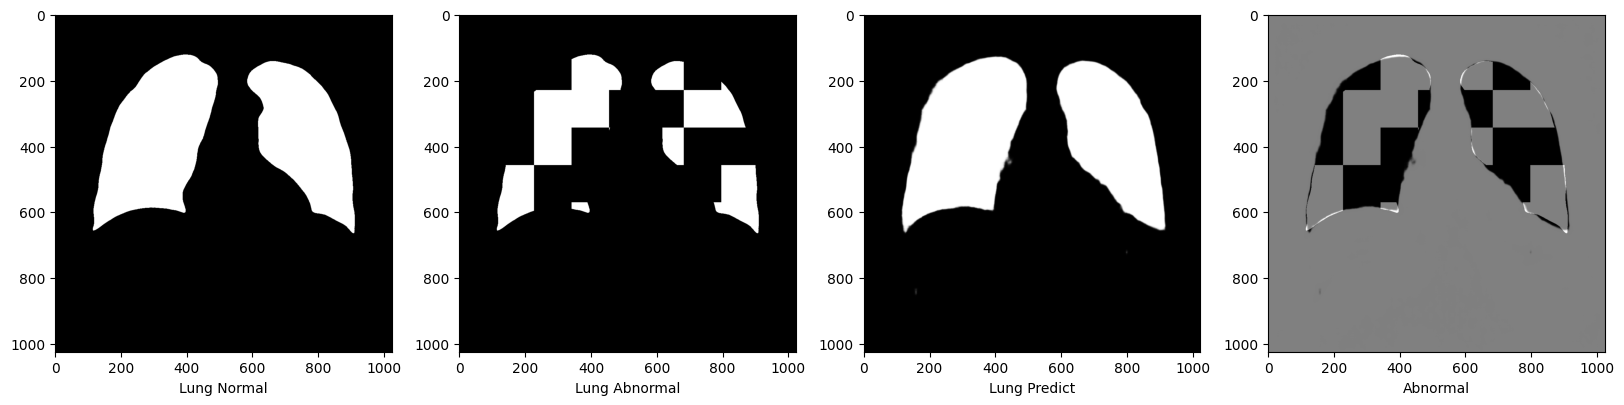

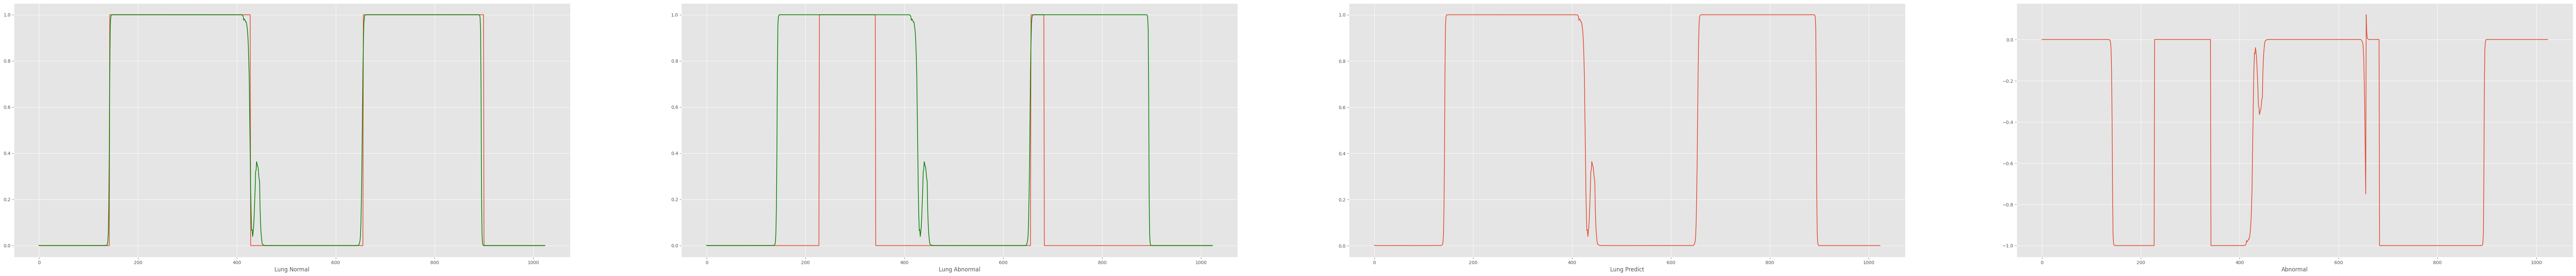

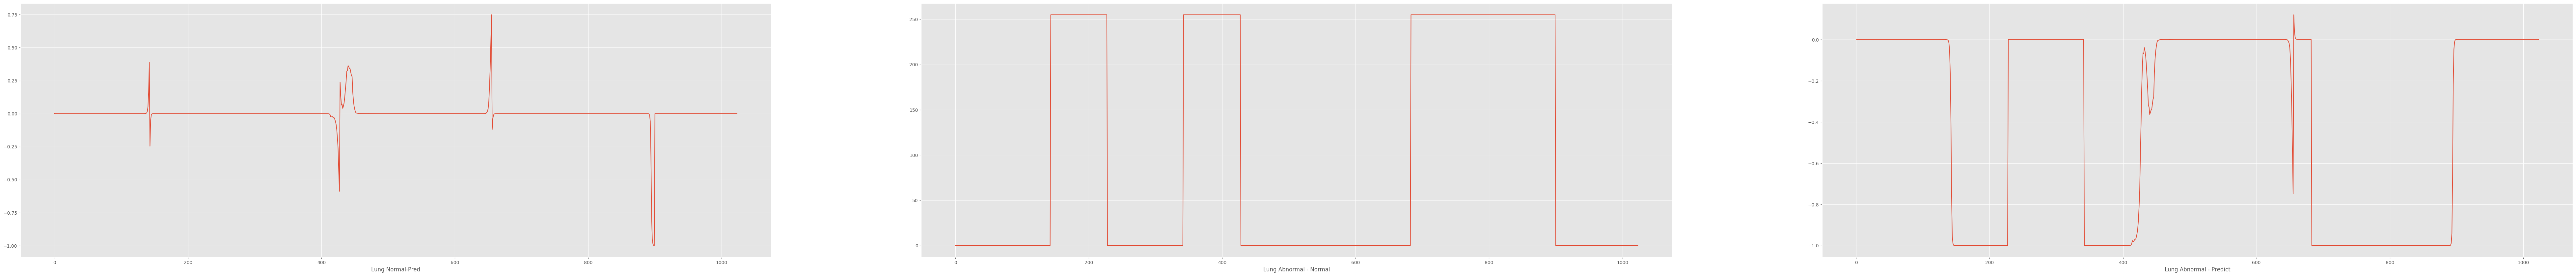

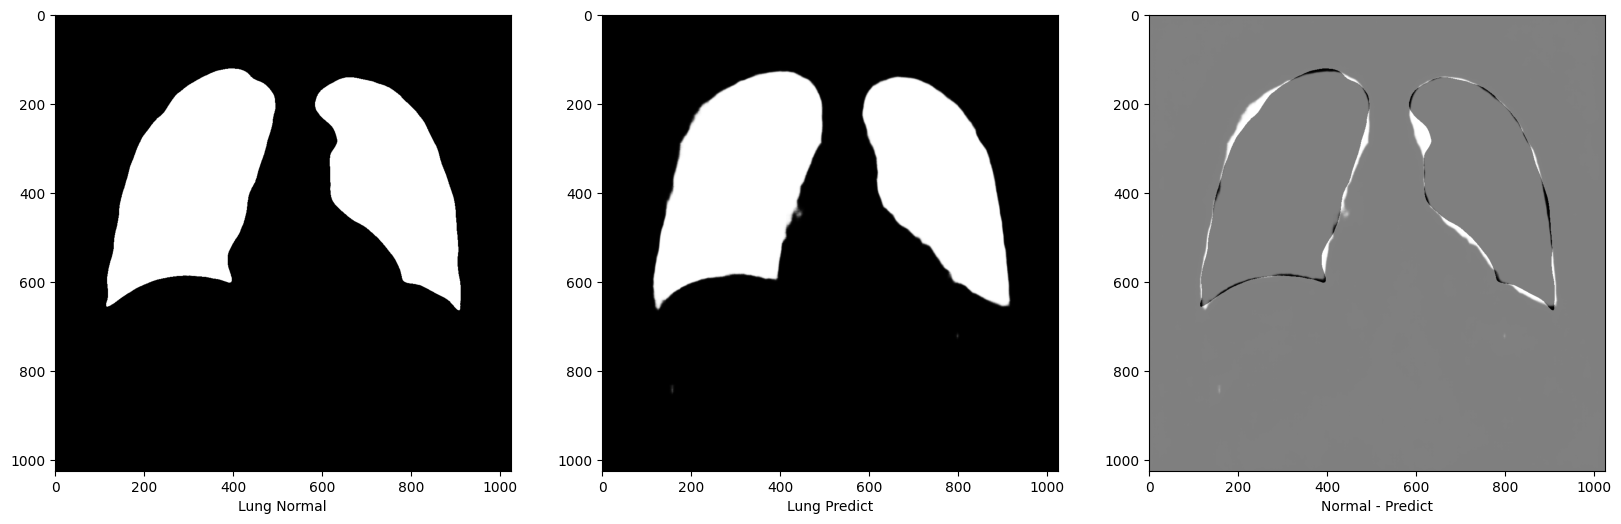

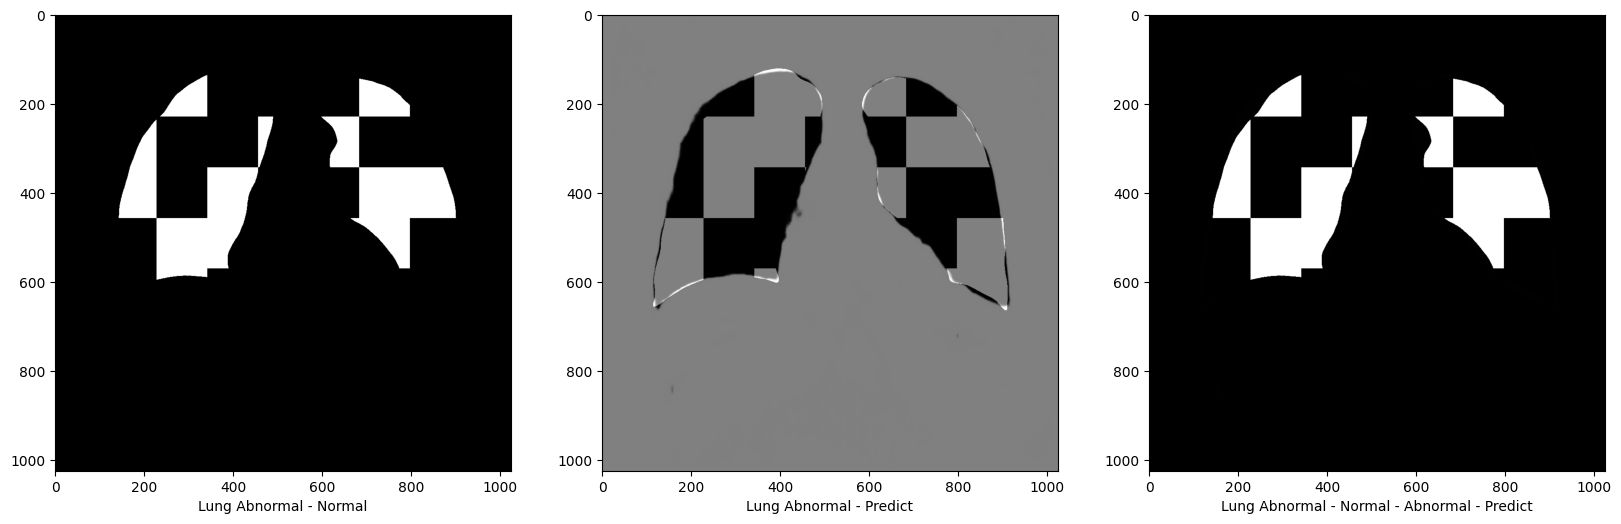

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,450)

## Model latent is d512 sigmoid

In [ ]:
args = {
    'filters' : (32,64,64,64,64),
    'latentDim' : 512,
    'model_name' : 'mask_d512_f32x64x4_ep100_sigmoid',
    'model_dir':'./model',
    'activation_all': False
}
model = DAE_Model(input_shape=(1024,1024,1),**args)

(512,)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_mask_d512_f32x64x4_ep100_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_mask_d512_f32x64x4_e (None, 512)               33685696  
_________________________________________________________________
decoder_mask_d512_f32x64x4_e (None, 1024, 1024, 1)     33787585  
Total params: 67,473,281
Trainable params: 67,472,129
Non-trainable params: 1,152
_________________________________________________________________


In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 20
bs = 5

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*5)
model.decay_steps

2365

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/20
473/473 [==============================] - 196s 393ms/step - loss: 0.0623 - lr: 9.9795e-04 - val_loss: 0.0339 - val_lr: 9.9187e-04

Epoch 00001: val_loss improved from inf to 0.03388, saving model to ./model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid/autoencoder_mask_d512_f32x64x4_ep100_sigmoid-0001-0.0339.h5
Epoch 2/20
473/473 [==============================] - 195s 413ms/step - loss: 0.0266 - lr: 9.8983e-04 - val_loss: 0.0256 - val_lr: 9.8380e-04

Epoch 00002: val_loss improved from 0.03388 to 0.02562, saving model to ./model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid/autoencoder_mask_d512_f32x64x4_ep100_sigmoid-0002-0.0256.h5
Epoch 3/20
473/473 [==============================] - 195s 412ms/step - loss: 0.0219 - lr: 9.8178e-04 - val_loss: 0.0223 - val_lr: 9.7580e-04

Epoch 00003: val_loss improved from 0.02562 to 0.02228, saving model to ./model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid/autoencoder_mask_d512_f32x64x4_ep100_sigmoid-00

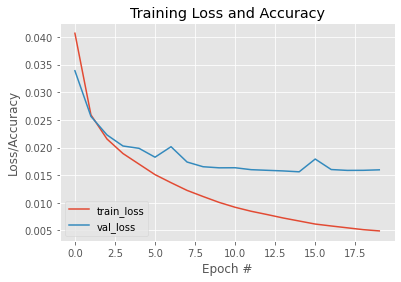

In [ ]:
model.plot_show()

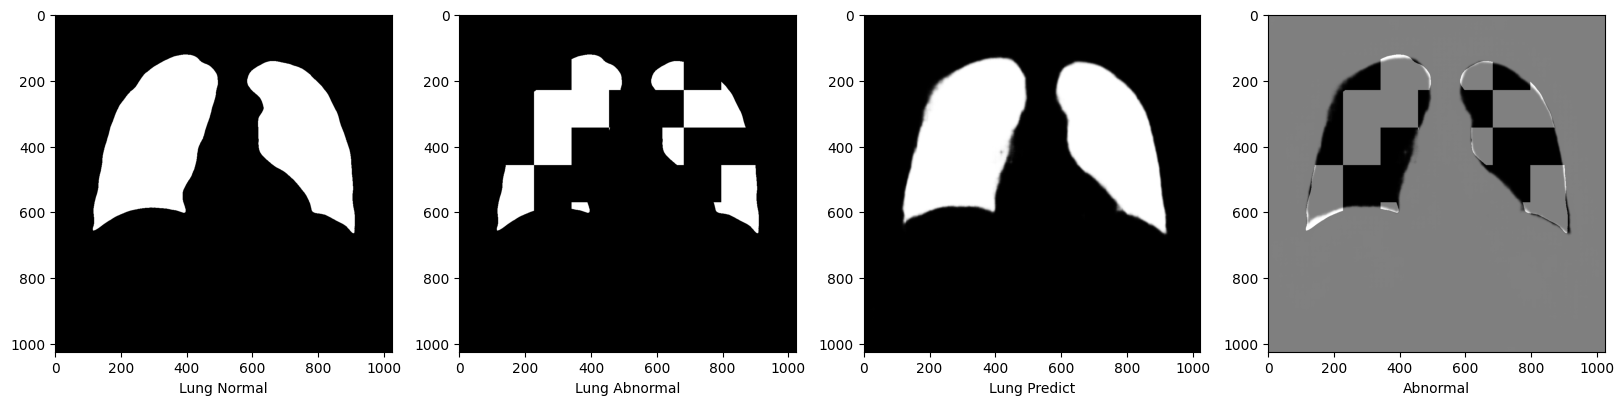

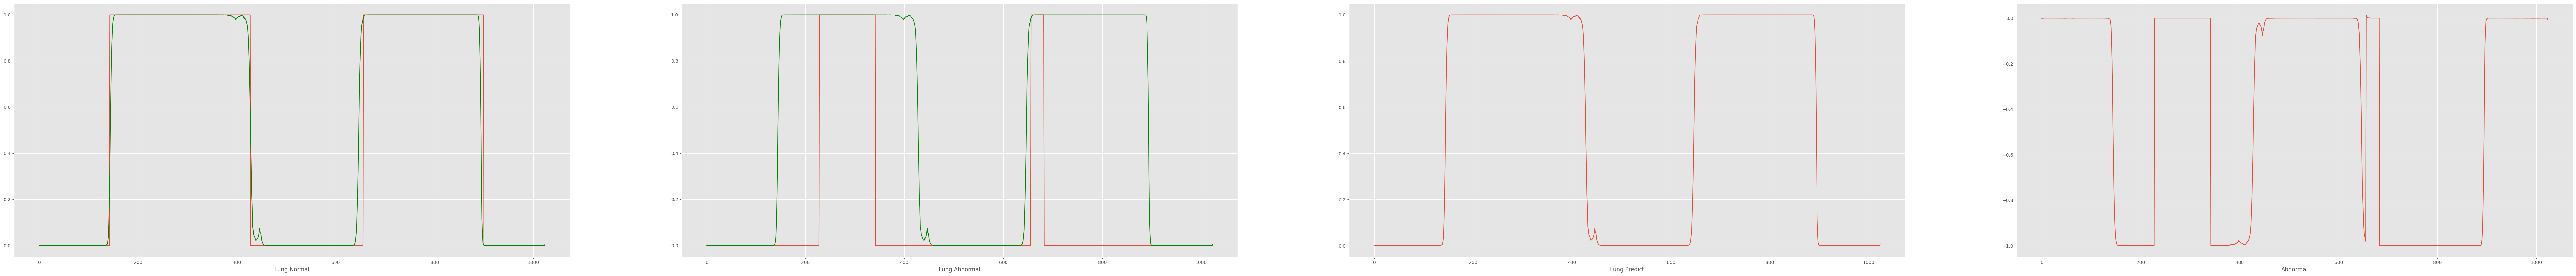

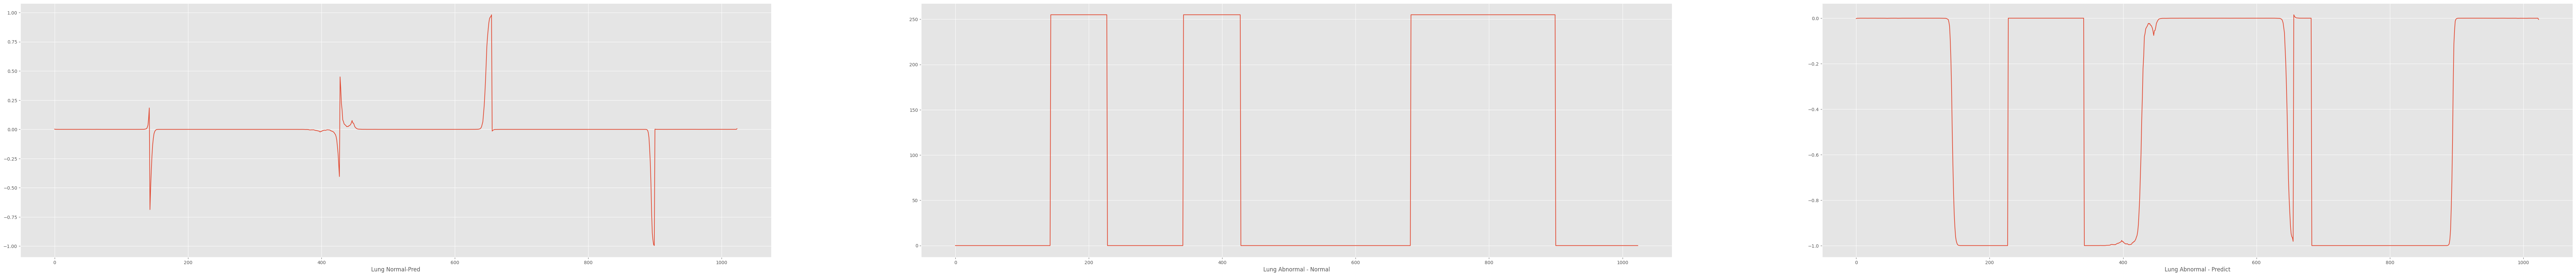

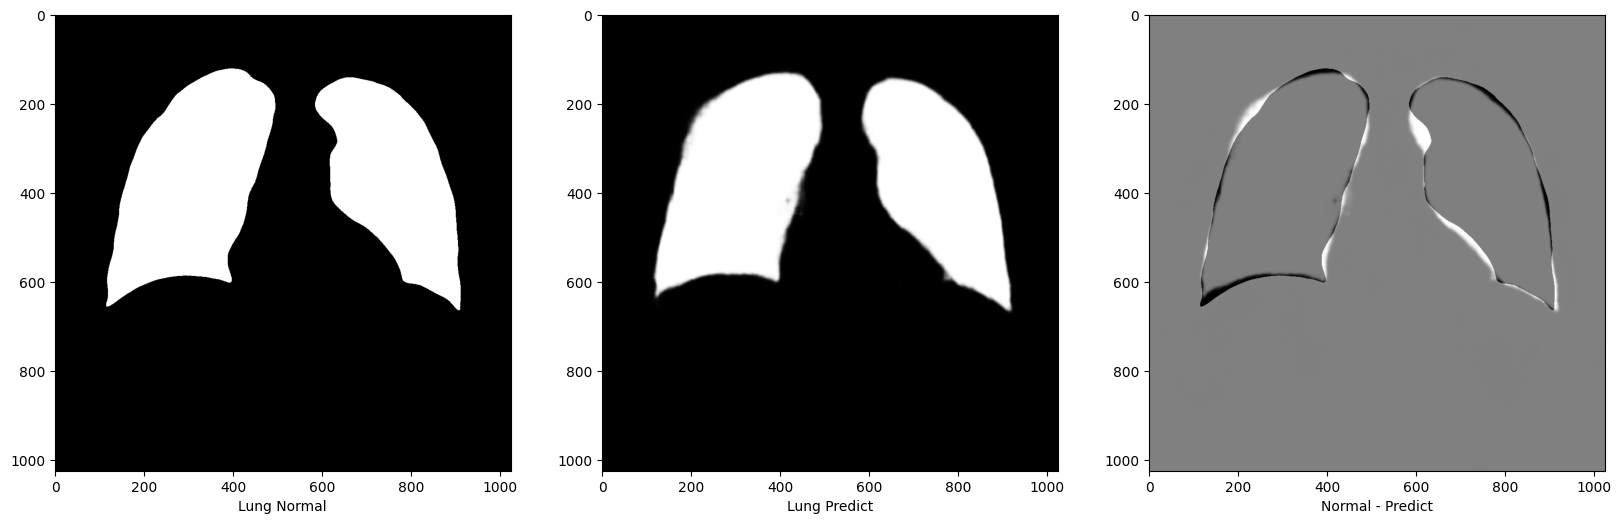

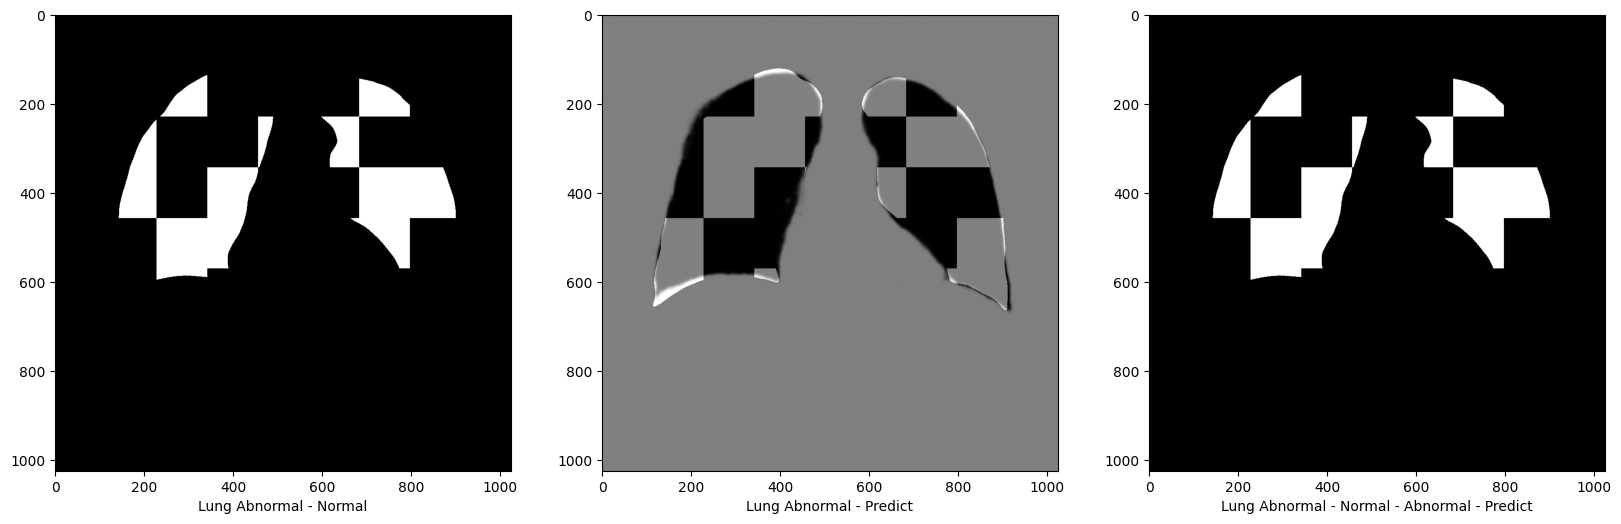

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,450)

## Model latent is d512 sigmoid maxpl

In [ ]:
args = {
    'filters' : (32,64,64,64,64),
    'latentDim' : 512,
    'model_name' : 'mask_d512_f32x64x4_ep100_sigmoid_maxpl',
    'model_dir':'./model',
    'activation_all': False
}
model = DAE_Model(input_shape=(1024,1024,1),**args)

(512,)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_mask_d512_f32x64x4_e (None, 512)               33685696  
_________________________________________________________________
decoder_mask_d512_f32x64x4_e (None, 1024, 1024, 1)     33787585  
Total params: 67,473,281
Trainable params: 67,472,129
Non-trainable params: 1,152
_________________________________________________________________


In [ ]:
model.encoder.summary()

Model: "encoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 1024, 32)    320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024, 1024, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024, 32)    128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (Leaky

In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 150
bs = 5

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*8)
model.decay_steps

3784

In [ ]:
model.fit(train_gen,val_gen,ep,bs,15)

Epoch 16/150
473/473 [==============================] - 115s 223ms/step - loss: 0.0588 - lr: 9.9872e-04 - val_loss: 0.0384 - val_lr: 9.9491e-04

Epoch 00016: val_loss improved from inf to 0.03845, saving model to ./model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl/autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl-0016-0.0384.h5
Epoch 17/150
473/473 [==============================] - 105s 221ms/step - loss: 0.0264 - lr: 9.9363e-04 - val_loss: 0.0236 - val_lr: 9.8985e-04

Epoch 00017: val_loss improved from 0.03845 to 0.02356, saving model to ./model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl/autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl-0017-0.0236.h5
Epoch 18/150
473/473 [==============================] - 105s 221ms/step - loss: 0.0217 - lr: 9.8857e-04 - val_loss: 0.0221 - val_lr: 9.8481e-04

Epoch 00018: val_loss improved from 0.02356 to 0.02211, saving model to ./model/checkpoint/autoencoder_mask_d512_f32x64x4_ep100_sigmoid_maxpl/autoencoder

In [ ]:
model.plot_show()

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,450)

## Model latent is d512 sigmoid, input 256x256

### Train

In [ ]:
args = {
    'filters' : (32,64,64),
    'latentDim' : 512,
    'model_name' : 'mask_i256x256_d512_f32x64x2_ep100_sigmoid',
    'model_dir':'./model',
    'activation_all': False
}
model = DAE_Model(input_shape=(256,256,1),**args)

(512,)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_mask_i256x256_d512_f (None, 512)               33611328  
_________________________________________________________________
decoder_mask_i256x256_d512_f (None, 256, 256, 1)       33713217  
Total params: 67,324,545
Trainable params: 67,323,905
Non-trainable params: 640
_________________________________________________________________


In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 100
bs = 5

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*3)
model.decay_steps

1419

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/100
473/473 [==============================] - 26s 38ms/step - loss: 0.0654 - lr: 9.9658e-04 - val_loss: 0.0451 - val_lr: 9.8649e-04

Epoch 00001: val_loss improved from inf to 0.04511, saving model to ./model/checkpoint/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid-0001-0.0451.h5
Epoch 2/100
473/473 [==============================] - 18s 39ms/step - loss: 0.0305 - lr: 9.8311e-04 - val_loss: 0.0266 - val_lr: 9.7315e-04

Epoch 00002: val_loss improved from 0.04511 to 0.02662, saving model to ./model/checkpoint/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid-0002-0.0266.h5
Epoch 3/100
473/473 [==============================] - 19s 39ms/step - loss: 0.0243 - lr: 9.6982e-04 - val_loss: 0.0253 - val_lr: 9.6000e-04

Epoch 00003: val_loss improved from 0.02662 to 0.02526, saving model to ./model/checkpoint/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid/autoe

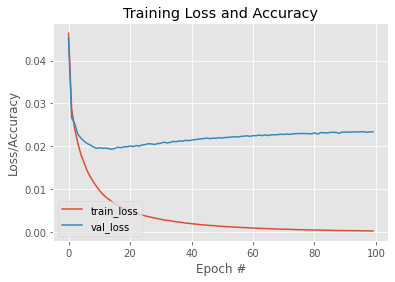

In [ ]:
model.plot_show()

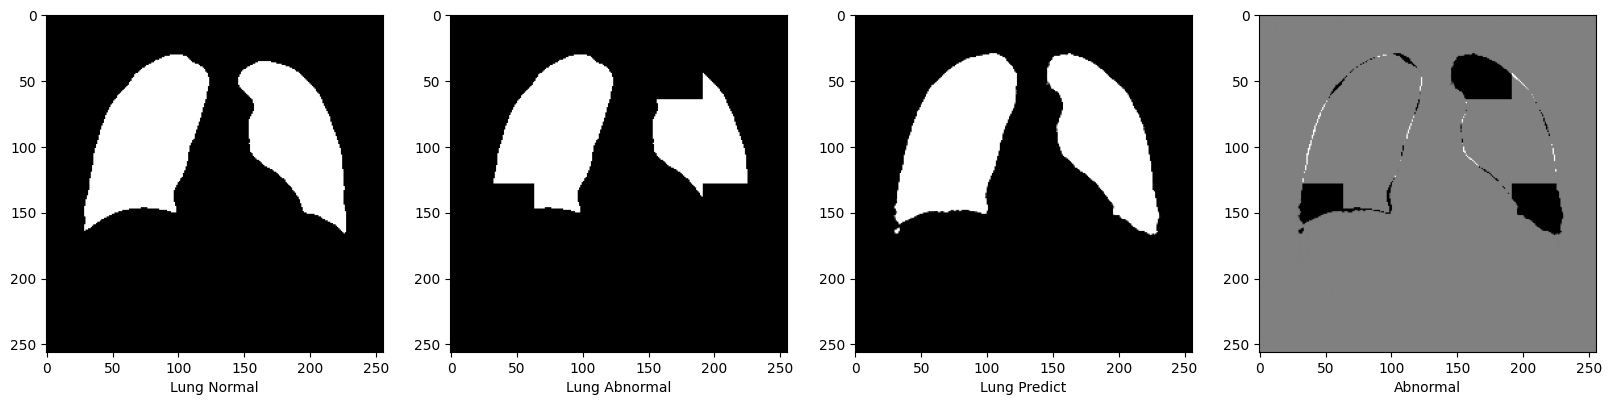

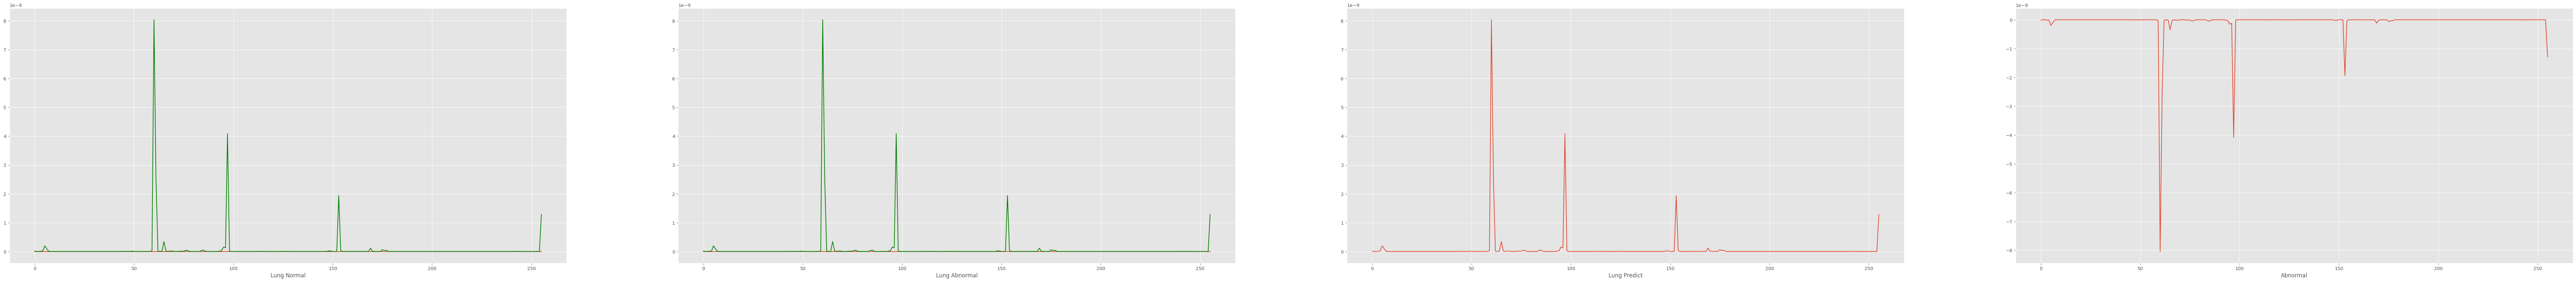

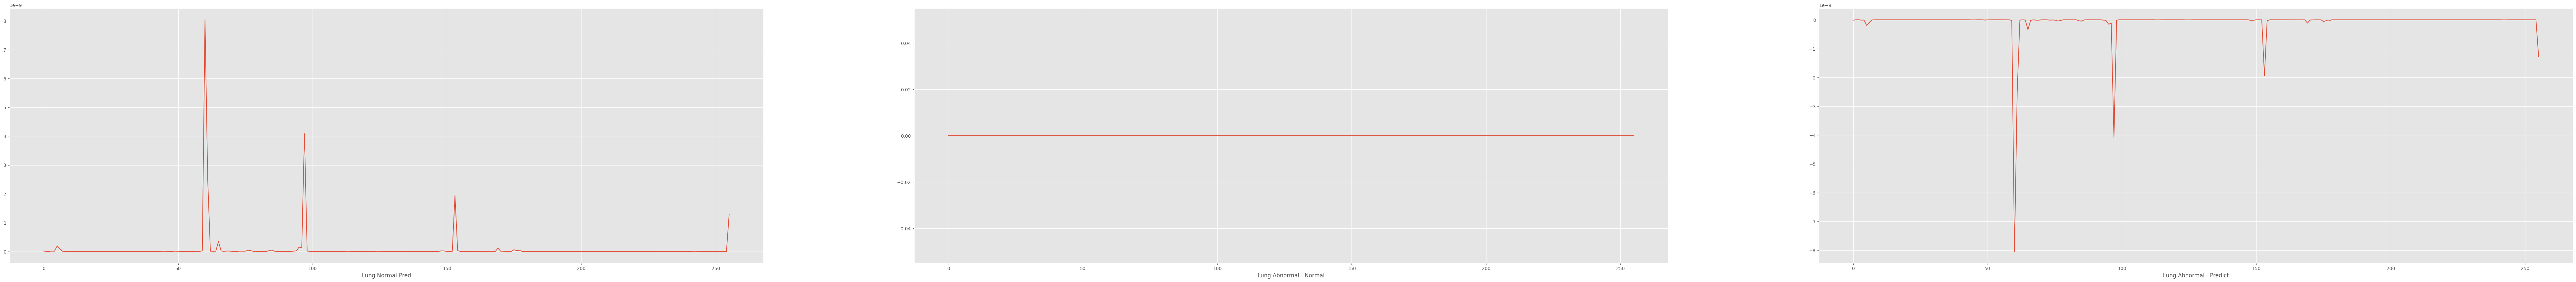

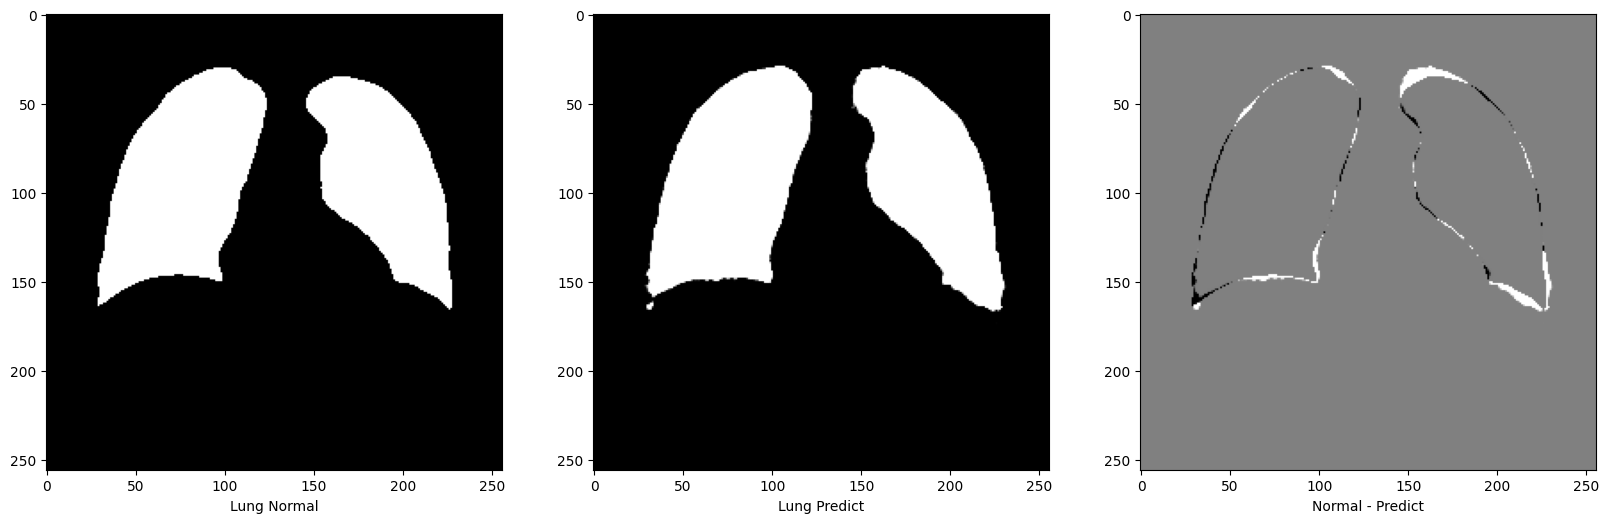

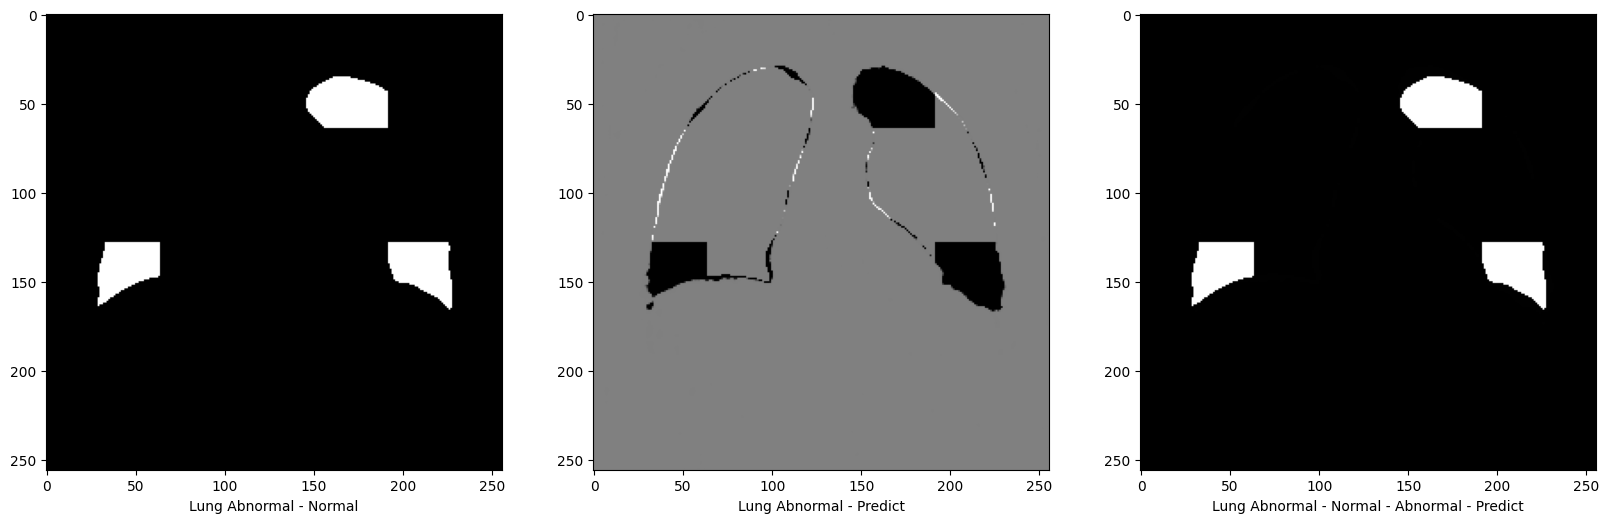

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,250)

### View

In [ ]:
best_path = './model/checkpoint/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d512_f32x64x2_ep100_sigmoid-0015-0.0193.h5'

In [ ]:
bestm = load_model(best_path,compile=False)

In [ ]:
t = bestm.predict(ytest[:10])

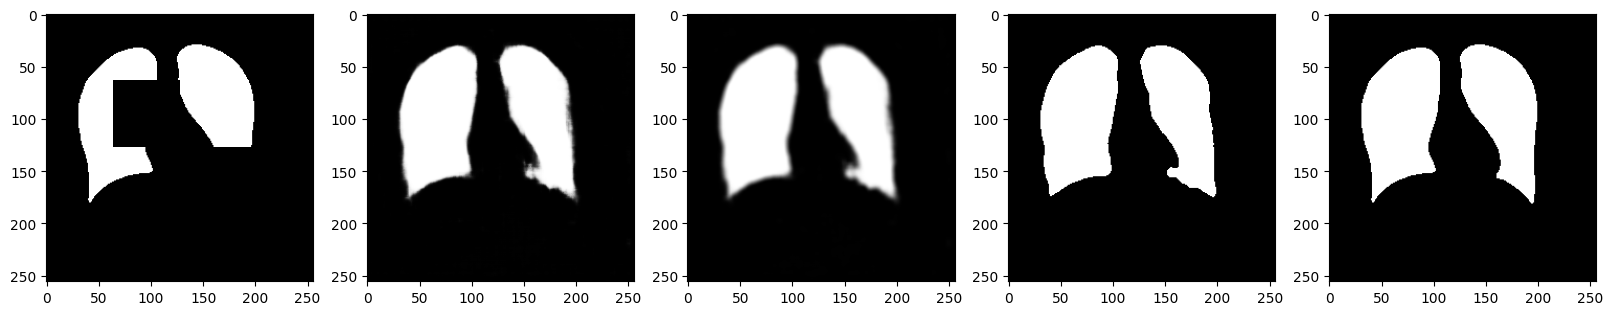

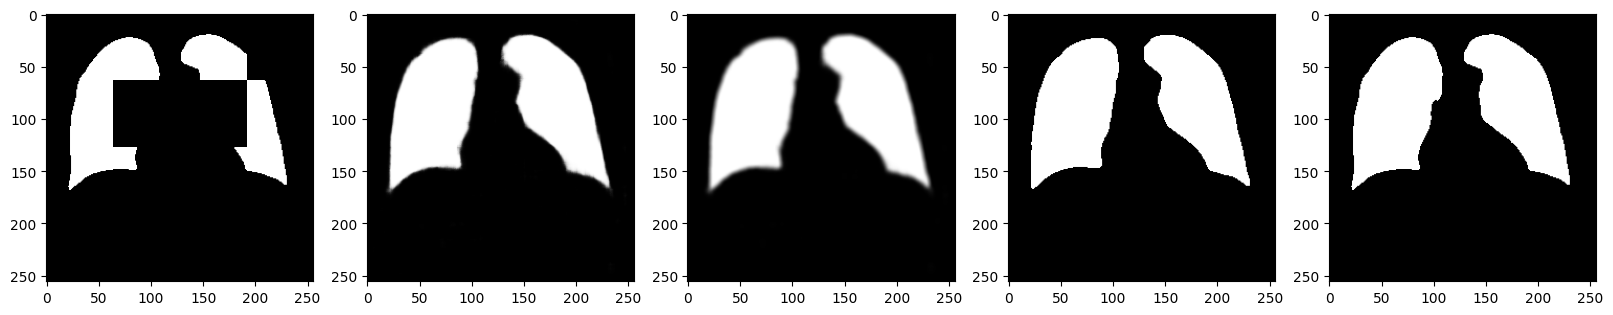

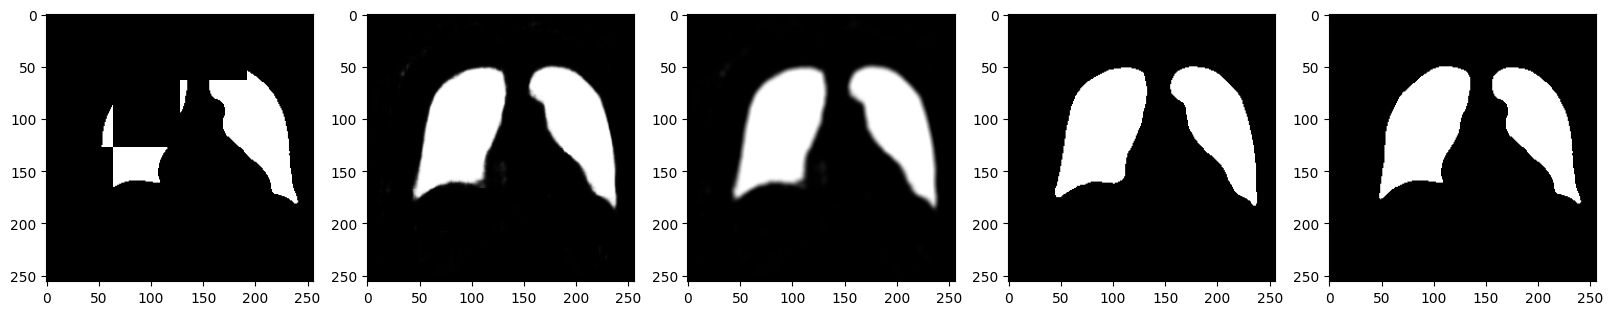

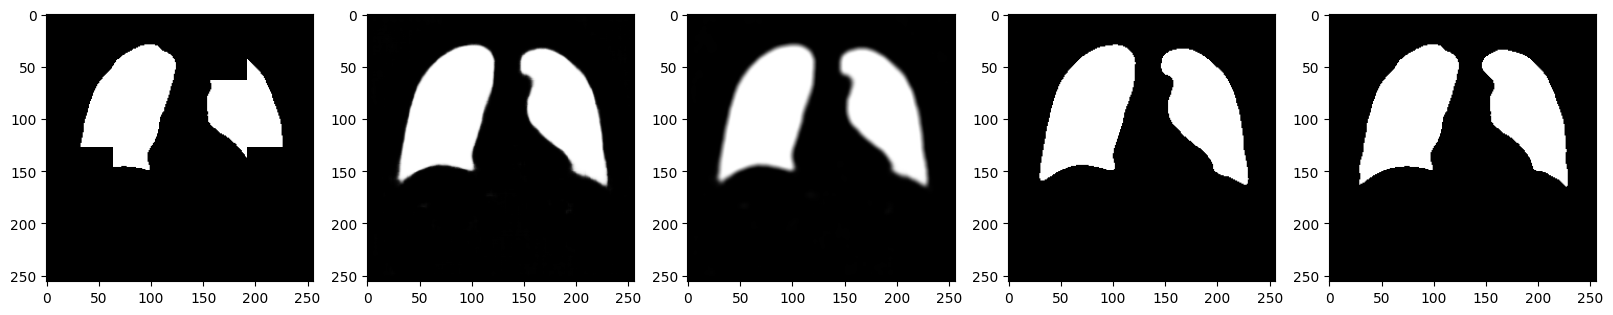

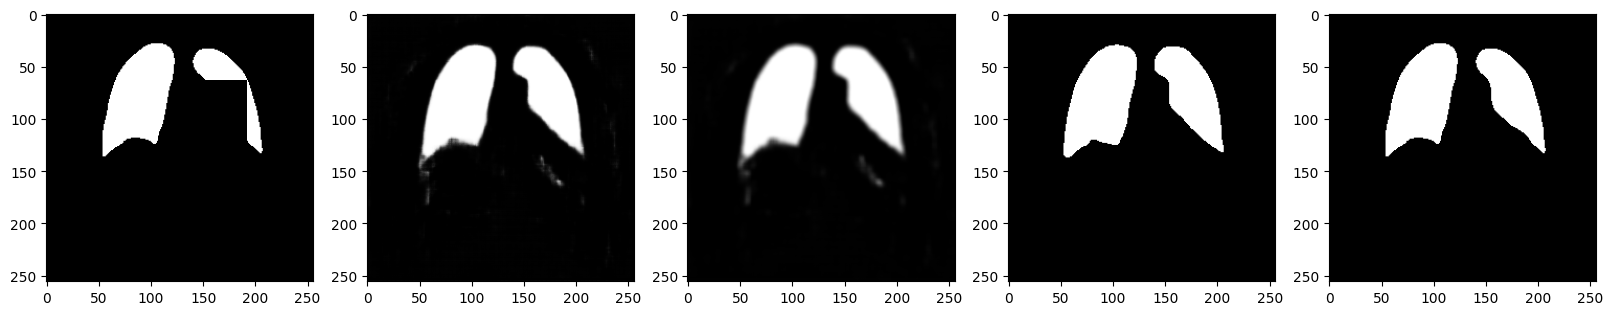

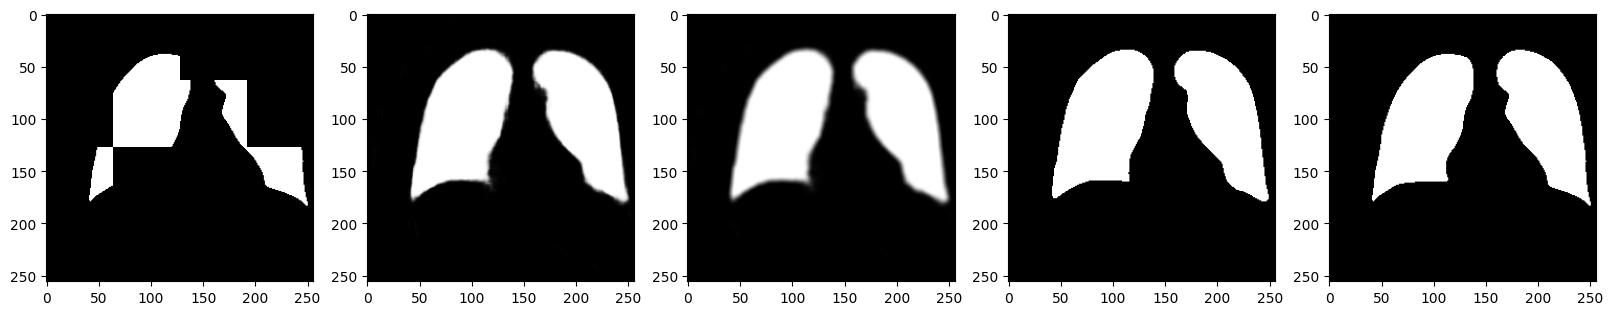

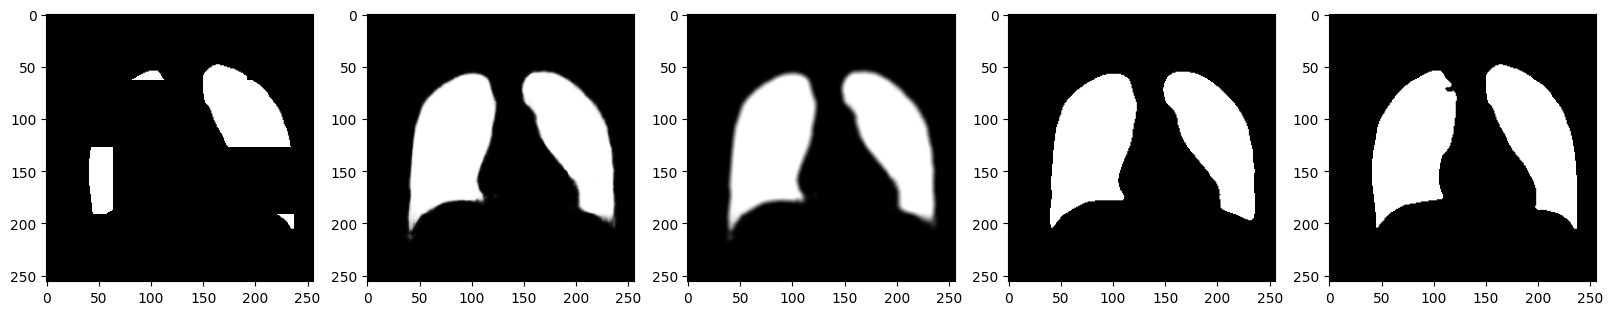

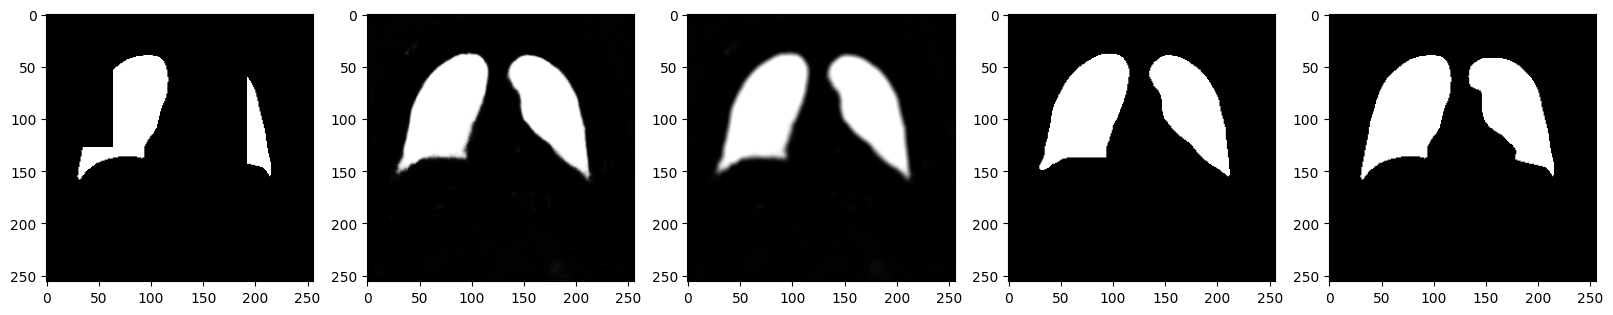

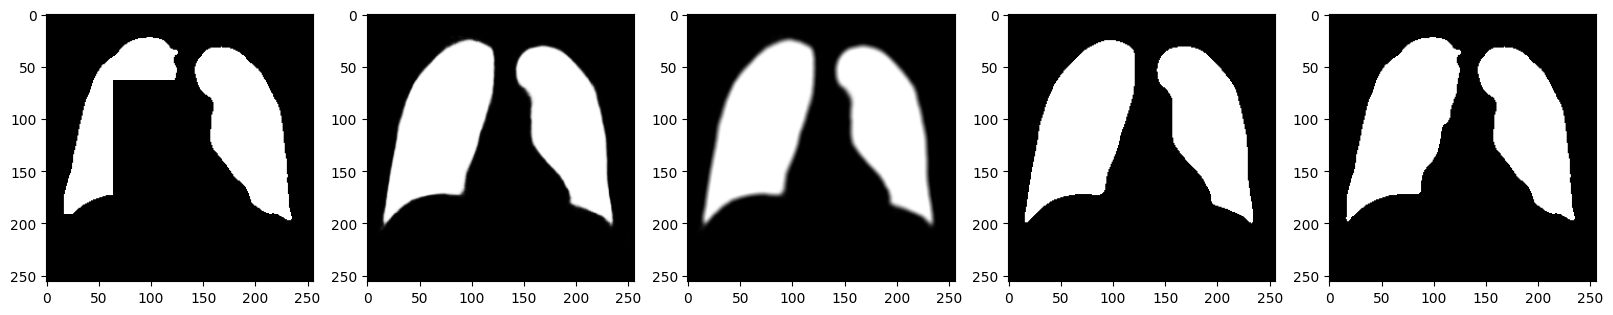

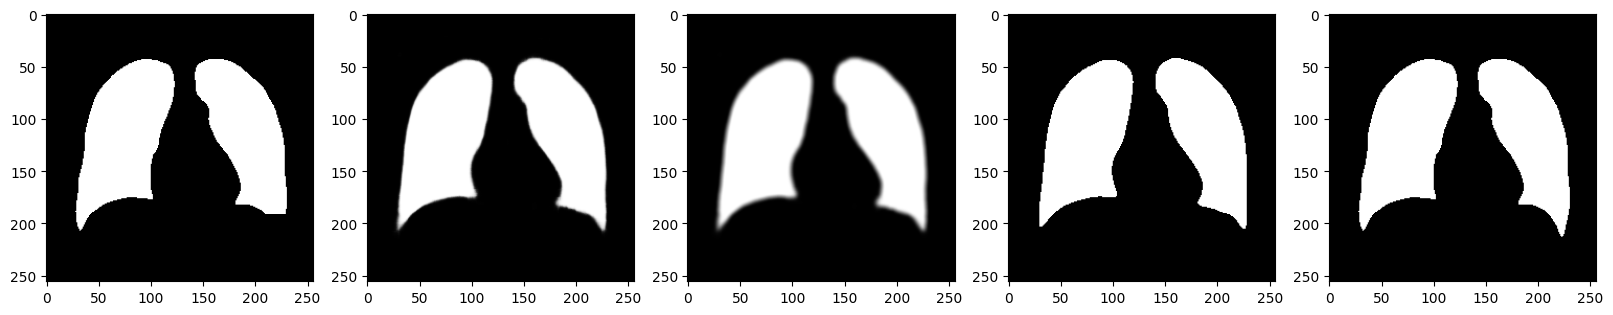

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(xtest[i,:,:,0],cmap='gray')
  plt.subplot(rows,cols,2)
  plt.imshow(t[i,:,:,0],cmap='gray')
  plt.subplot(rows,cols,3)
  blur_img = cv2.blur(t[i,:,:,0],(5,5))
  plt.imshow(blur_img,cmap='gray')
  plt.subplot(rows,cols,4)
  blur_img[blur_img<0.5] = 0
  blur_img[blur_img>0.5] = 1
  plt.imshow(blur_img,cmap='gray')
  plt.subplot(rows,cols,5)
  plt.imshow(ytest[i,:,:,0],cmap='gray')
  plt.show()

In [ ]:
xfinal = bestm.predict(xtest,batch_size=5)

In [ ]:
xblur0_5 = np.array([cv2.blur(xf,(5,5)) for xf in xfinal])
xblur0_15 = np.array([cv2.blur(xf,(5,5)) for xf in xfinal])

In [ ]:
xblurmean = 0.5
xblur0_5[xblur0_5 < xblurmean] = 0
xblur0_5[xblur0_5 >= xblurmean] = 1
xblurmean = 0.15
xblur0_15[xblur0_15 < xblurmean] = 0
xblur0_15[xblur0_15 >= xblurmean] = 1

In [ ]:
iou_score(ytest[:,:,:,0],xblur)

0.25075708204700103

In [ ]:
iou_score(ytest[:,:,:,0],xblur0_5)

0.9073693947802266

In [ ]:
iou_score(ytest[:,:,:,0],xblur0_15)

0.8818990848810039

In [ ]:
xblurs = np.arange(0.02,0.8,0.02)

In [ ]:
xblurs = np.arange(0.02,0.8,0.02)
scores = []
for i in xblurs:
  xblur = np.array([cv2.blur(xf,(5,5)) for xf in xfinal])
  xblur[xblur < i] = 0
  xblur[xblur >= i] = 1
  scores.append(iou_score(ytest[:,:,:,0],xblur))

In [ ]:
scores = np.array(scores)

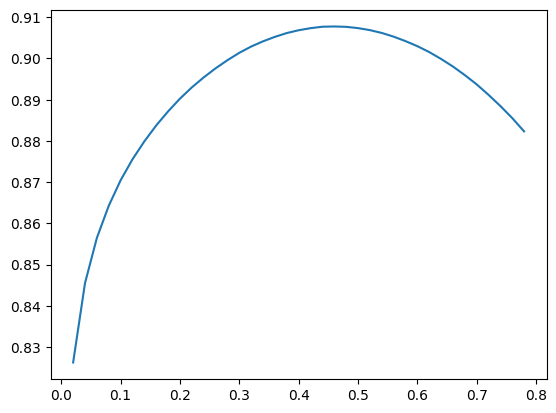

In [ ]:
plt.plot(xblurs,scores)

In [ ]:
bsindex = scores.argmax()

In [ ]:
print('best score: ',scores[bsindex])
print('best mean blur: ',xblurs[bsindex])

best score:  0.907763565798687
best mean blur:  0.46


## Model latent is d256 sigmoid, input 256x256

### Train

In [ ]:
args = {
    'filters' : (32,64,64),
    'latentDim' : 256,
    'model_name' : 'mask_i256x256_d256_f32x64x2_ep100_sigmoid',
    'model_dir':'./model',
    'activation_all': False
}
model = DAE_Model(input_shape=(256,256,1),**args)

(256,)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_mask_i256x256_d256_f (None, 256)               16833856  
_________________________________________________________________
decoder_mask_i256x256_d256_f (None, 256, 256, 1)       16936001  
Total params: 33,769,857
Trainable params: 33,769,217
Non-trainable params: 640
_________________________________________________________________


In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 50
bs = 5

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*3)
model.decay_steps

1419

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/50
473/473 [==============================] - 17s 33ms/step - loss: 0.0654 - lr: 9.9658e-04 - val_loss: 0.0386 - val_lr: 9.8649e-04

Epoch 00001: val_loss improved from inf to 0.03855, saving model to ./model/checkpoint/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid-0001-0.0386.h5
Epoch 2/50
473/473 [==============================] - 15s 33ms/step - loss: 0.0298 - lr: 9.8311e-04 - val_loss: 0.0278 - val_lr: 9.7315e-04

Epoch 00002: val_loss improved from 0.03855 to 0.02784, saving model to ./model/checkpoint/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid-0002-0.0278.h5
Epoch 3/50
473/473 [==============================] - 15s 32ms/step - loss: 0.0237 - lr: 9.6982e-04 - val_loss: 0.0244 - val_lr: 9.6000e-04

Epoch 00003: val_loss improved from 0.02784 to 0.02436, saving model to ./model/checkpoint/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid/autoenco

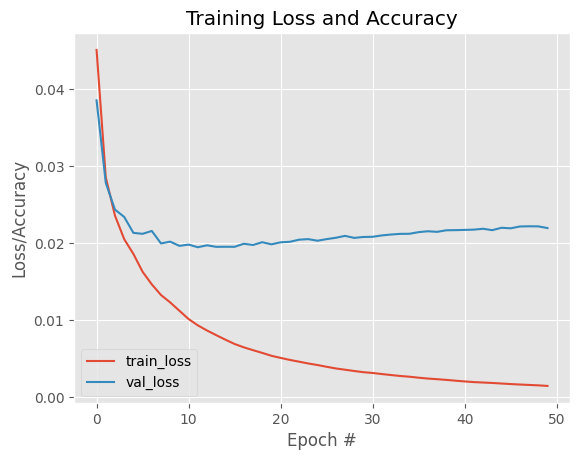

In [ ]:
model.plot_show()

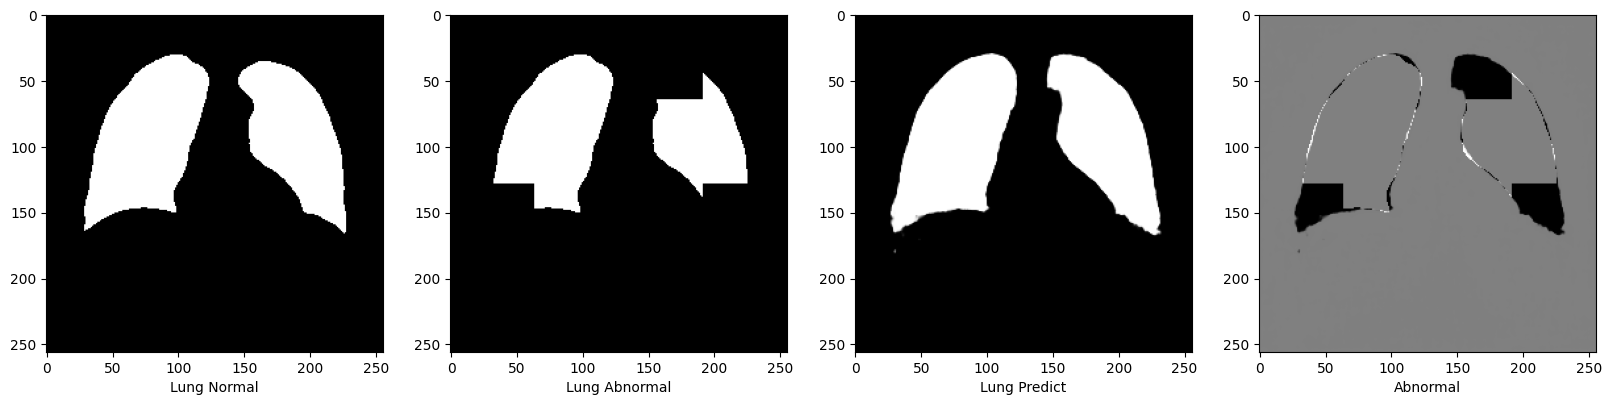

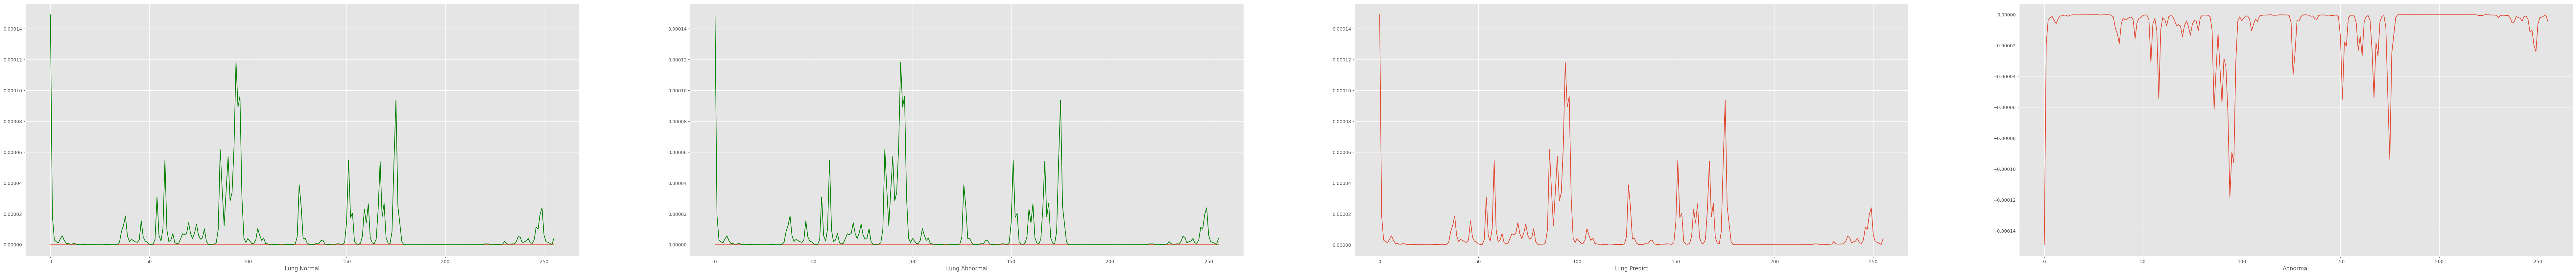

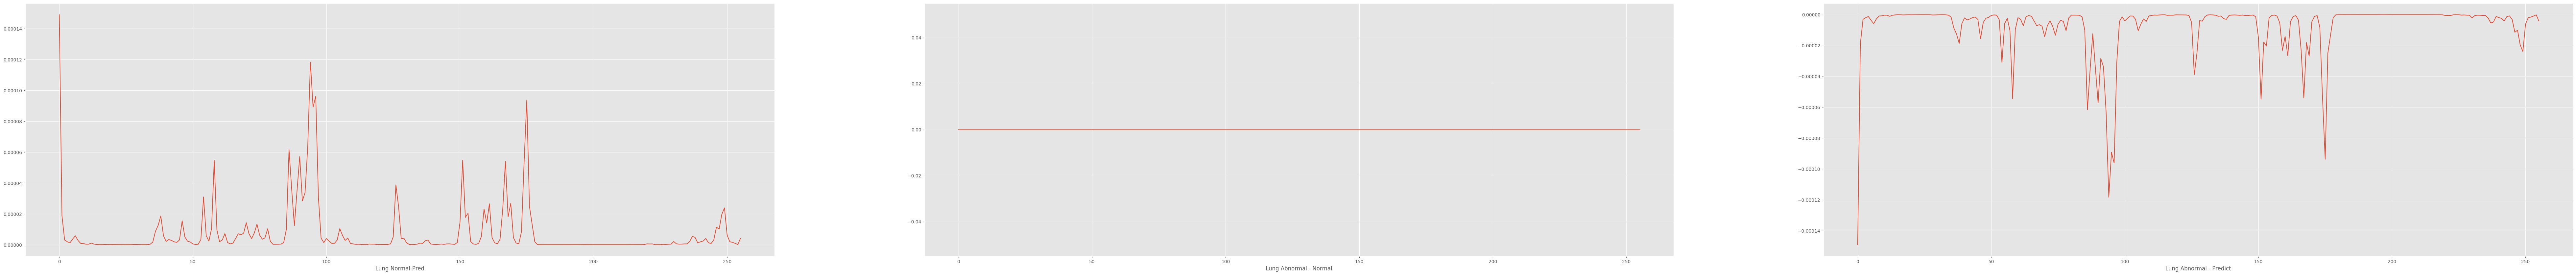

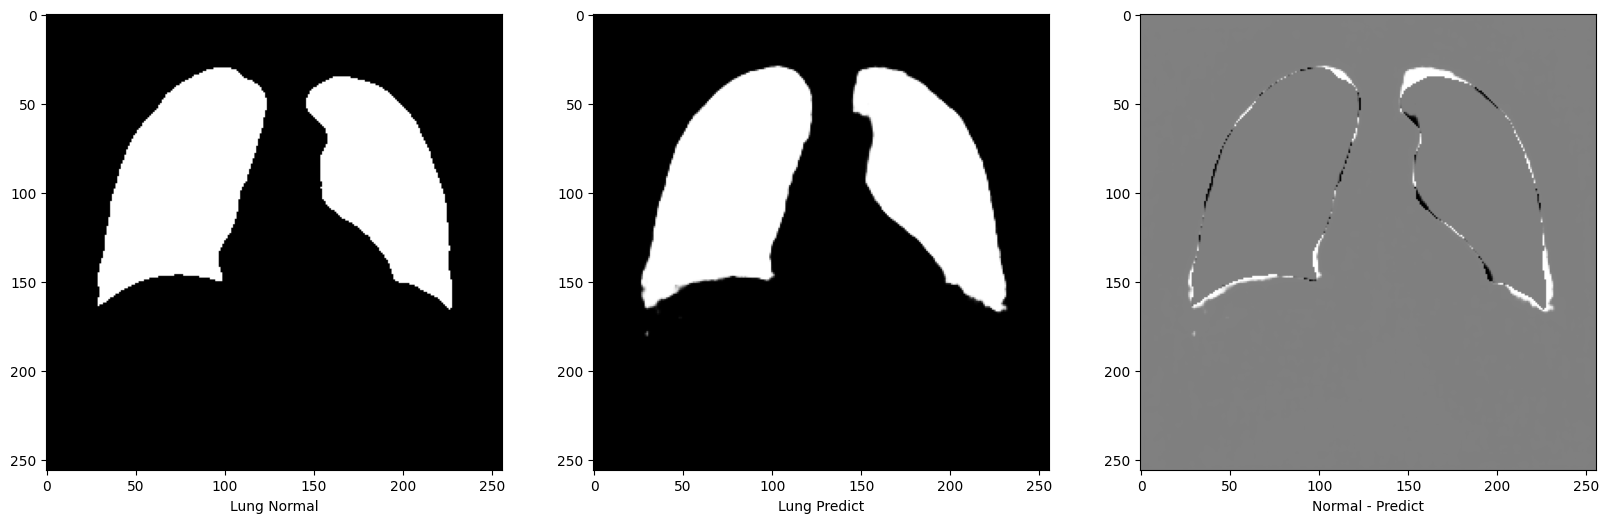

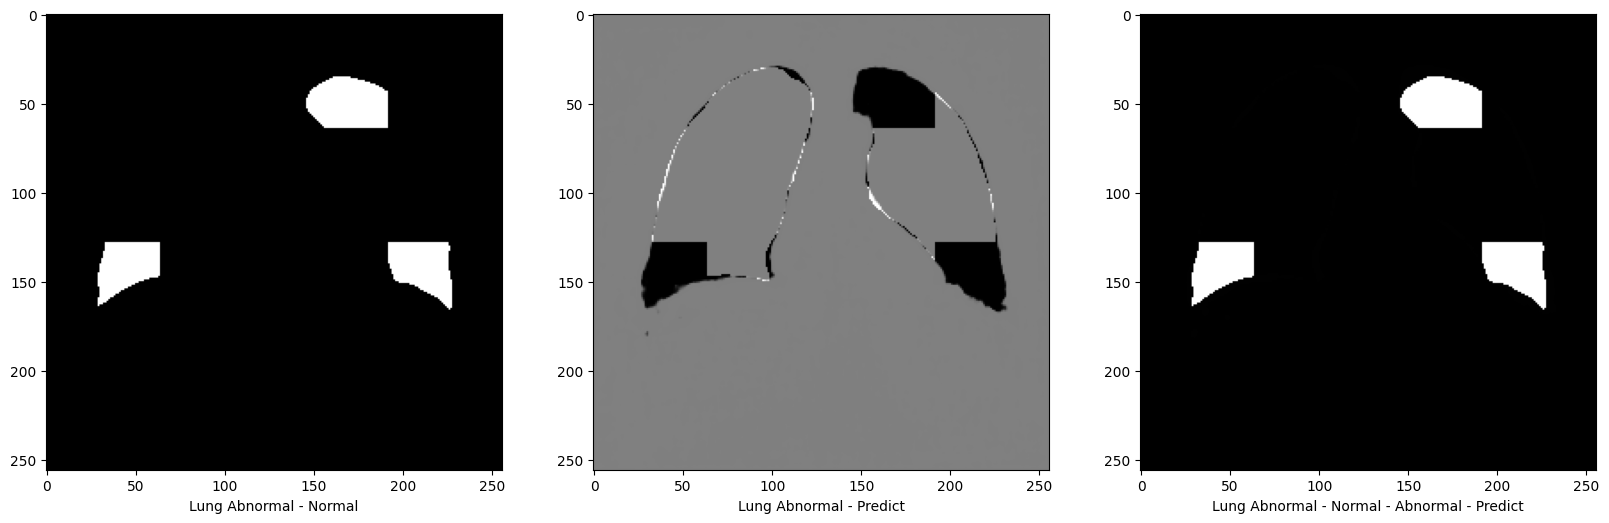

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,250)

### View

In [ ]:
best_path = './model/checkpoint/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid/autoencoder_mask_i256x256_d256_f32x64x2_ep100_sigmoid-0012-0.0195.h5'

In [ ]:
bestm = load_model(best_path,compile=False)

In [ ]:
t = bestm.predict(ytest[:10])

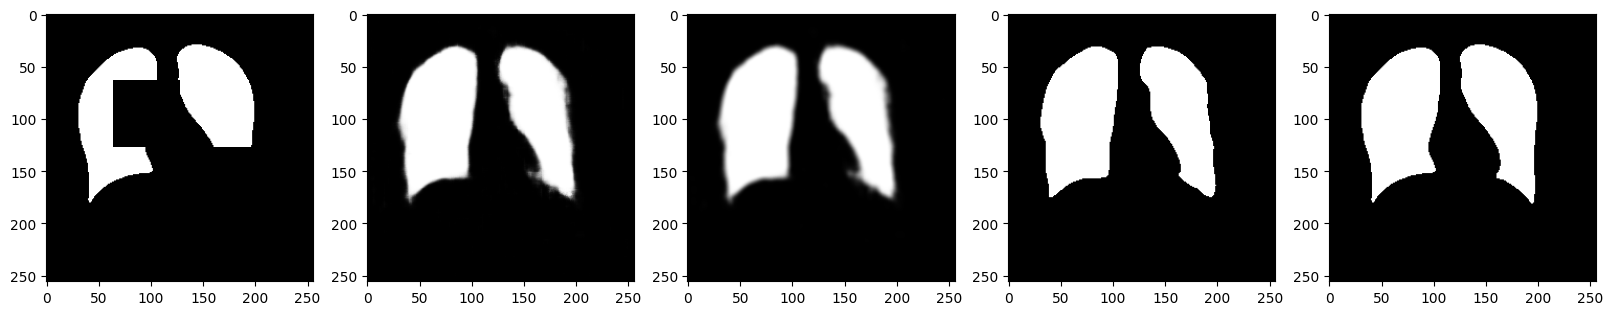

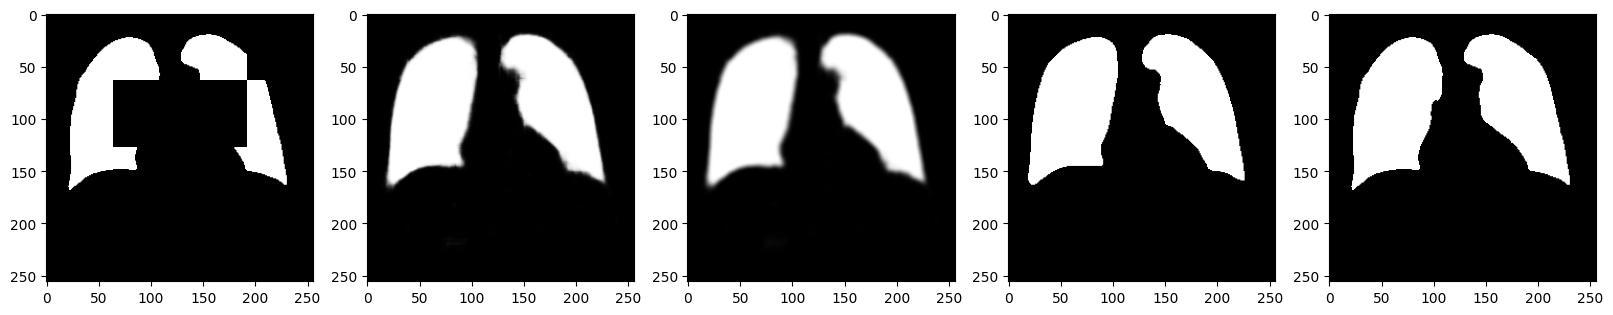

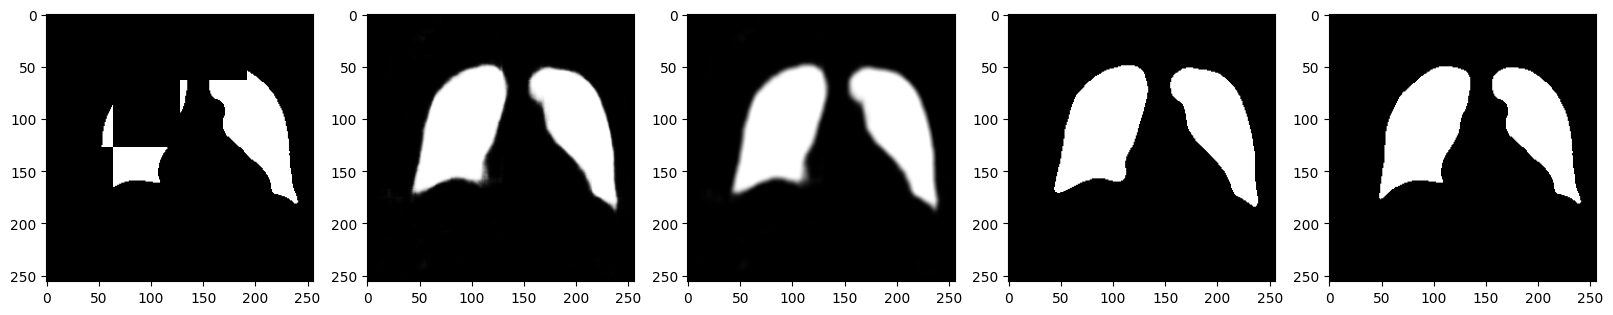

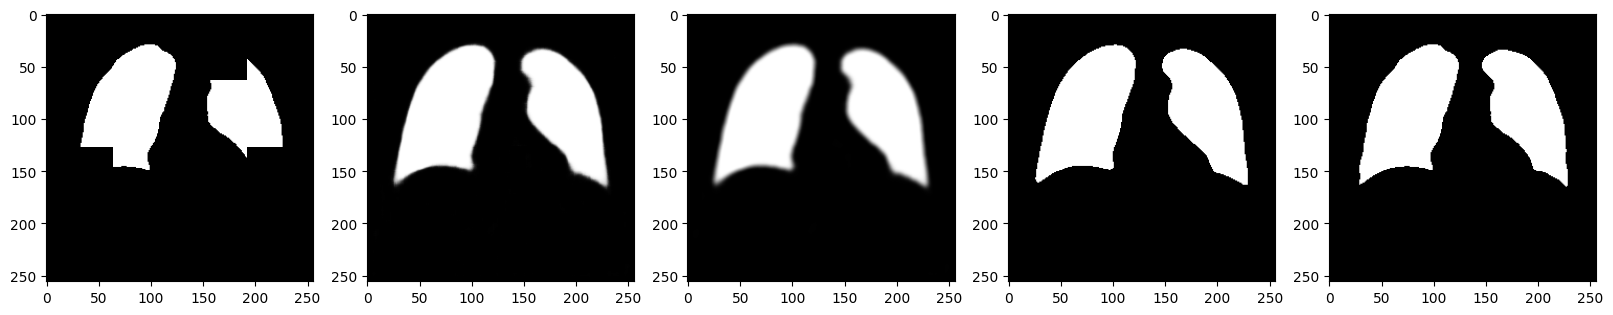

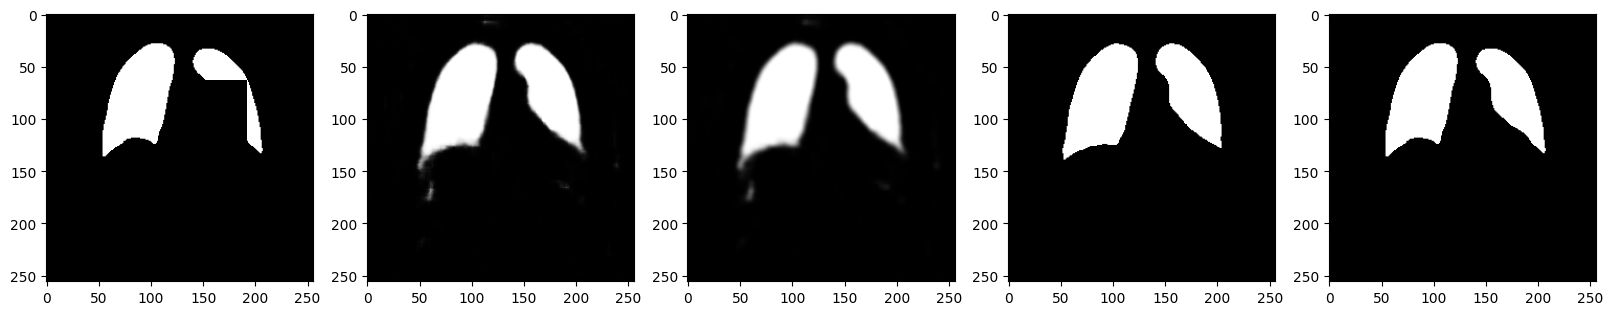

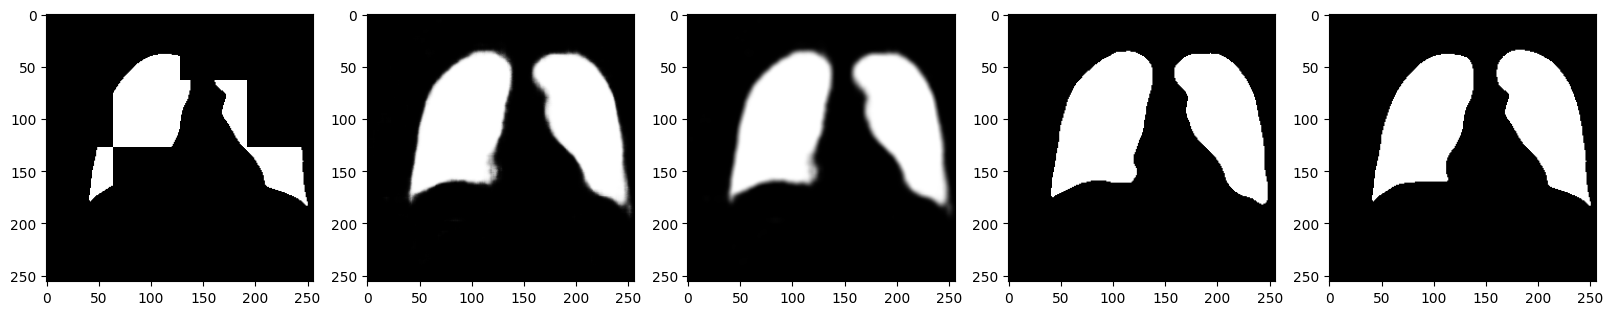

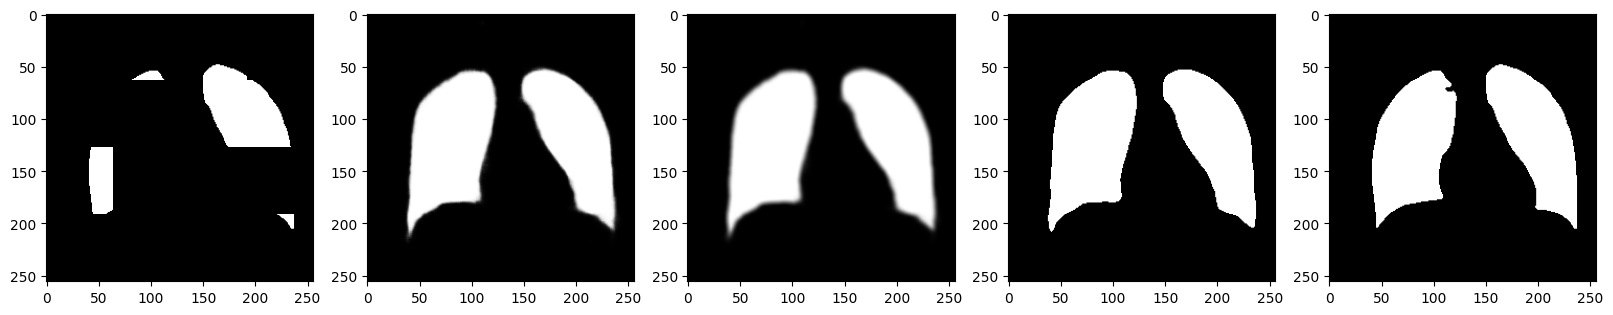

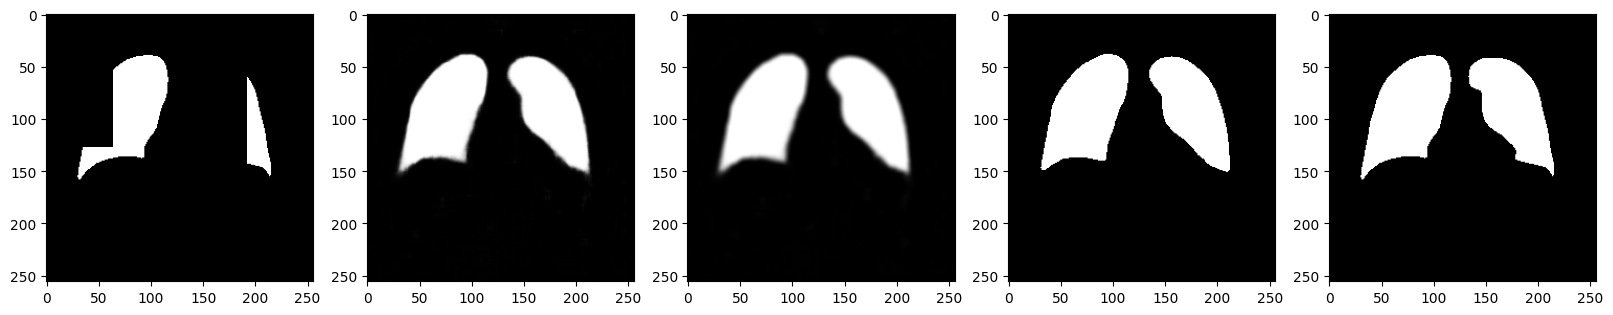

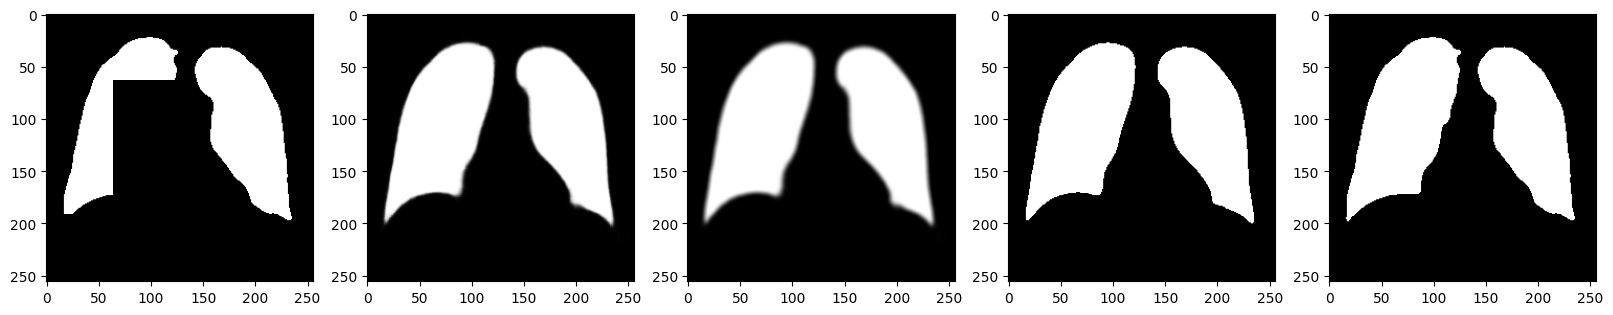

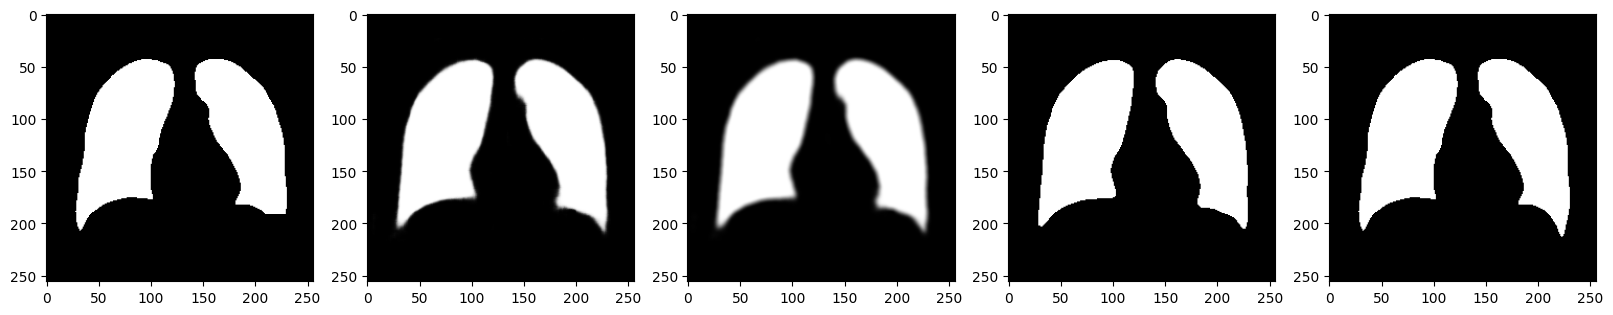

In [ ]:
rows = 1
cols = 5
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.subplot(rows,cols,1)
  plt.imshow(xtest[i,:,:,0],cmap='gray')
  plt.subplot(rows,cols,2)
  plt.imshow(t[i,:,:,0],cmap='gray')
  plt.subplot(rows,cols,3)
  blur_img = cv2.blur(t[i,:,:,0],(5,5))
  plt.imshow(blur_img,cmap='gray')
  plt.subplot(rows,cols,4)
  blur_img[blur_img<0.5] = 0
  blur_img[blur_img>0.5] = 1
  plt.imshow(blur_img,cmap='gray')
  plt.subplot(rows,cols,5)
  plt.imshow(ytest[i,:,:,0],cmap='gray')
  plt.show()

In [ ]:
xfinal = bestm.predict(xtest,batch_size=5)

In [ ]:
xblur0_5 = np.array([cv2.blur(xf,(5,5)) for xf in xfinal])
xblur0_15 = np.array([cv2.blur(xf,(5,5)) for xf in xfinal])

In [ ]:
xblurmean = 0.5
xblur0_5[xblur0_5 < xblurmean] = 0
xblur0_5[xblur0_5 >= xblurmean] = 1
xblurmean = 0.15
xblur0_15[xblur0_15 < xblurmean] = 0
xblur0_15[xblur0_15 >= xblurmean] = 1

In [ ]:
iou_score(ytest[:,:,:,0],xblur)

0.8823208776912685

In [ ]:
iou_score(ytest[:,:,:,0],xblur0_5)

0.9043370463084935

In [ ]:
iou_score(ytest[:,:,:,0],xblur0_15)

0.8730468388838551

In [ ]:
xblurs = np.arange(0.02,0.8,0.02)

In [ ]:
scores = []
for i in xblurs:
  xblur = np.array([cv2.blur(xf,(5,5)) for xf in xfinal])
  xblur[xblur < i] = 0
  xblur[xblur >= i] = 1
  scores.append(iou_score(ytest[:,:,:,0],xblur))
scores = np.array(scores)

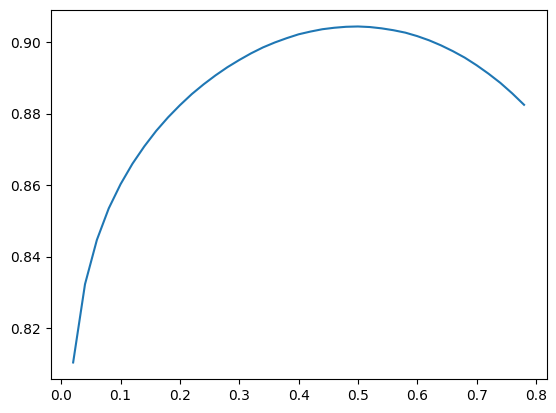

In [ ]:
plt.plot(xblurs,scores)

In [ ]:
bsindex = scores.argmax()
print('best score: ',scores[bsindex])
print('best mean blur: ',xblurs[bsindex])

best score:  0.9043370463084935
best mean blur:  0.5


In [ ]:
xblurs = np.arange(0.4,0.6,0.001)
xblurs.shape

(200,)

In [ ]:
scores = []
for i in xblurs:
  xblur = np.array([cv2.blur(xf,(5,5)) for xf in xfinal])
  xblur[xblur < i] = 0
  xblur[xblur >= i] = 1
  scores.append(iou_score(ytest[:,:,:,0],xblur))
scores = np.array(scores)

best score:  0.9043370463084935
best mean blur:  0.5000000000000001


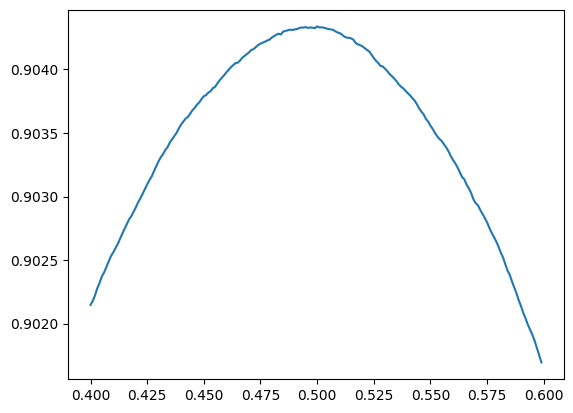

In [ ]:
plt.plot(xblurs,scores)
bsindex = scores.argmax()
print('best score: ',scores[bsindex])
print('best mean blur: ',xblurs[bsindex])

## Model mask_c128x128x64x6_f32x64x2_ep150_sigmoid

In [ ]:
args = {
    'filters' : (32,64,64),
    'latent_filters':(64,64,64,64,64),
    'latentDim' : None,
    'model_name' : 'mask_c128x128x64x6_f32x64x2_ep150_sigmoid',
    'model_dir':'./model',
}
model = DAE_Model(input_shape=(1024,1024,1),**args)

(128, 128, 64)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_mask_c128x128x64x6_f (None, 128, 128, 64)      242304    
_________________________________________________________________
decoder_mask_c128x128x64x6_f (None, 1024, 1024, 1)     279169    
Total params: 521,473
Trainable params: 519,553
Non-trainable params: 1,920
_________________________________________________________________


In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 50
bs = 5

In [ ]:
xtrain.shape

(2368, 1024, 1024, 1)

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*5)
model.decay_steps

2365

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/50
473/473 [==============================] - 204s 425ms/step - loss: 0.0319 - lr: 9.9795e-04 - val_loss: 0.5374 - val_lr: 9.9187e-04

Epoch 00001: val_loss improved from inf to 0.53740, saving model to ./model/checkpoint/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid-0001-0.5374.h5
Epoch 2/50
473/473 [==============================] - 201s 426ms/step - loss: 0.0109 - lr: 9.8983e-04 - val_loss: 0.3579 - val_lr: 9.8380e-04

Epoch 00002: val_loss improved from 0.53740 to 0.35790, saving model to ./model/checkpoint/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid-0002-0.3579.h5
Epoch 3/50
473/473 [==============================] - 201s 426ms/step - loss: 0.0097 - lr: 9.8178e-04 - val_loss: 0.3879 - val_lr: 9.7580e-04

Epoch 00003: val_loss did not improve from 0.35790
Epoch 4/50
473/473 [==============================] - 201s 425ms/step - loss: 0.0092 - lr: 9.738

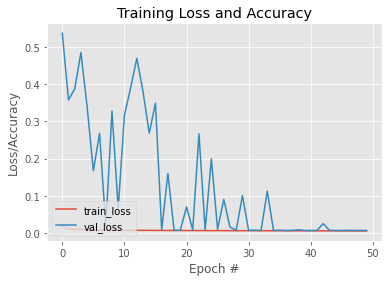

In [ ]:
model.plot_show()

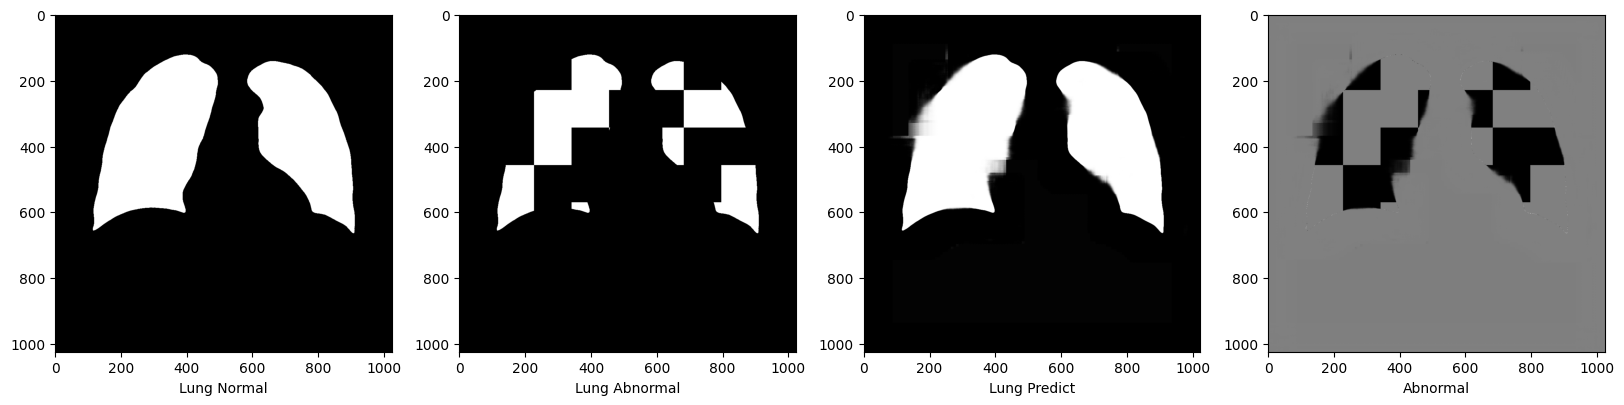

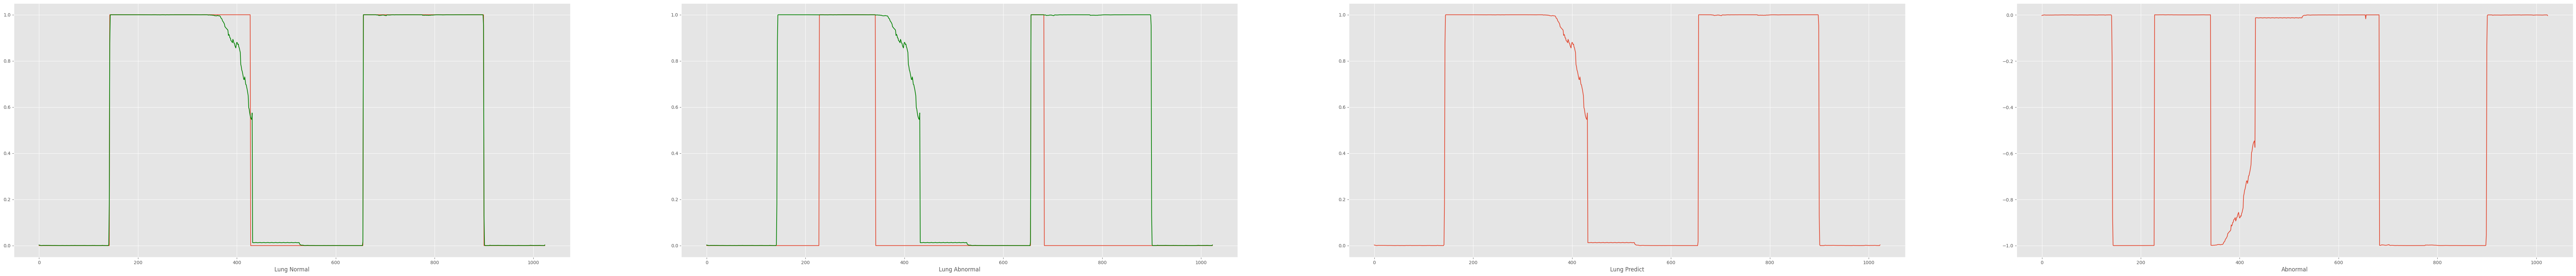

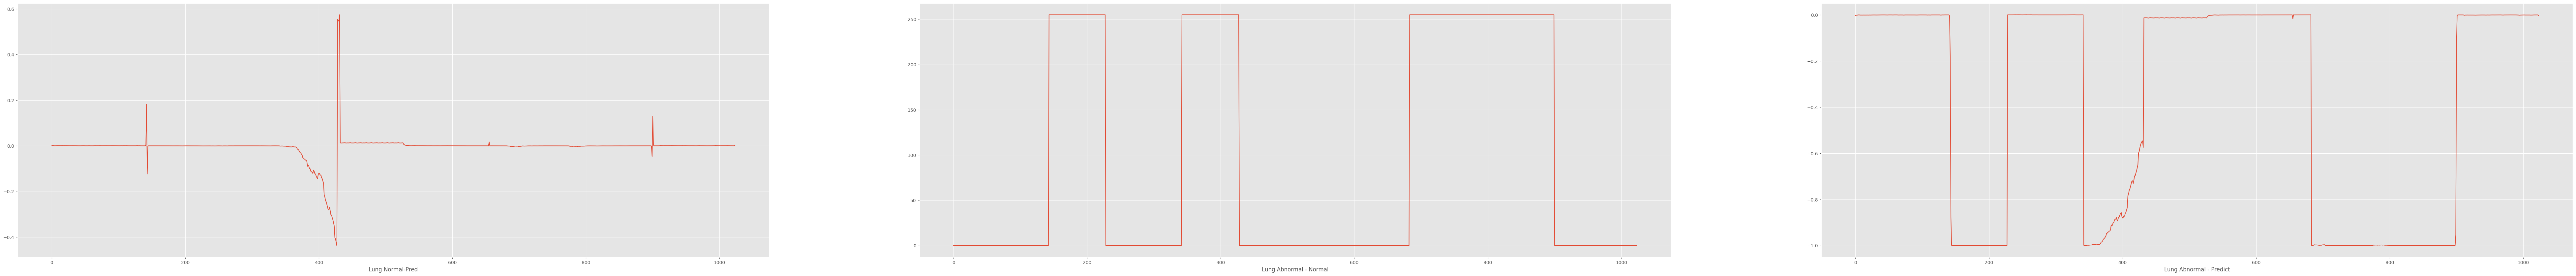

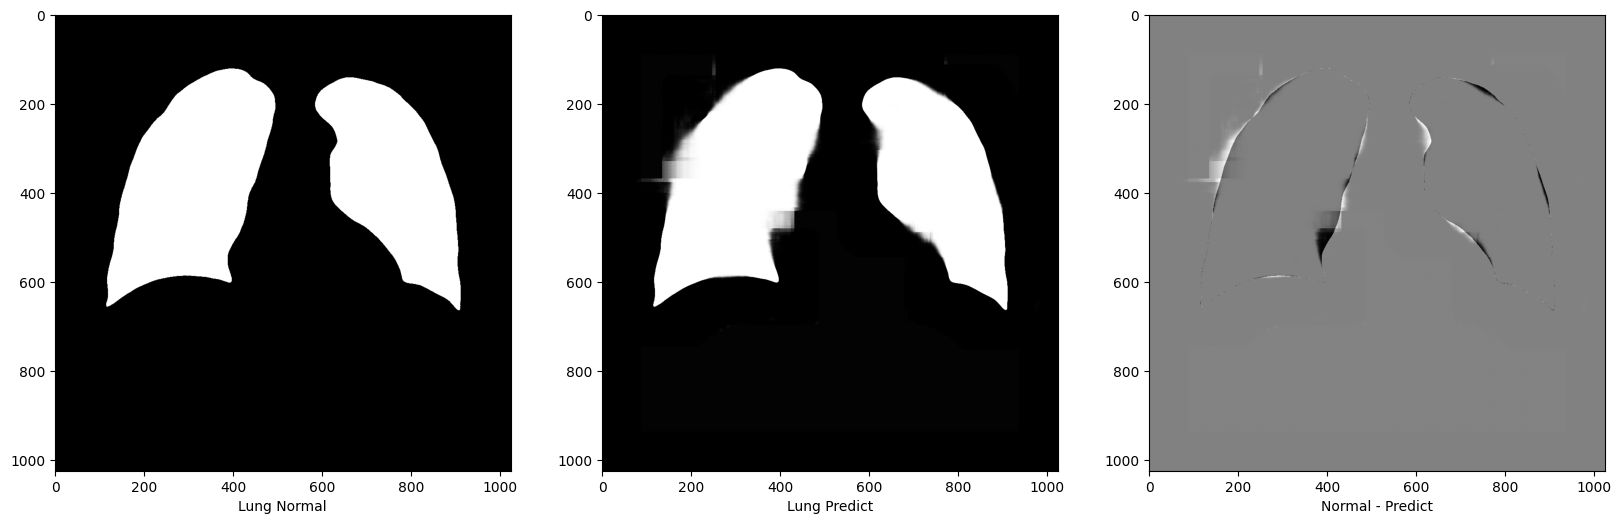

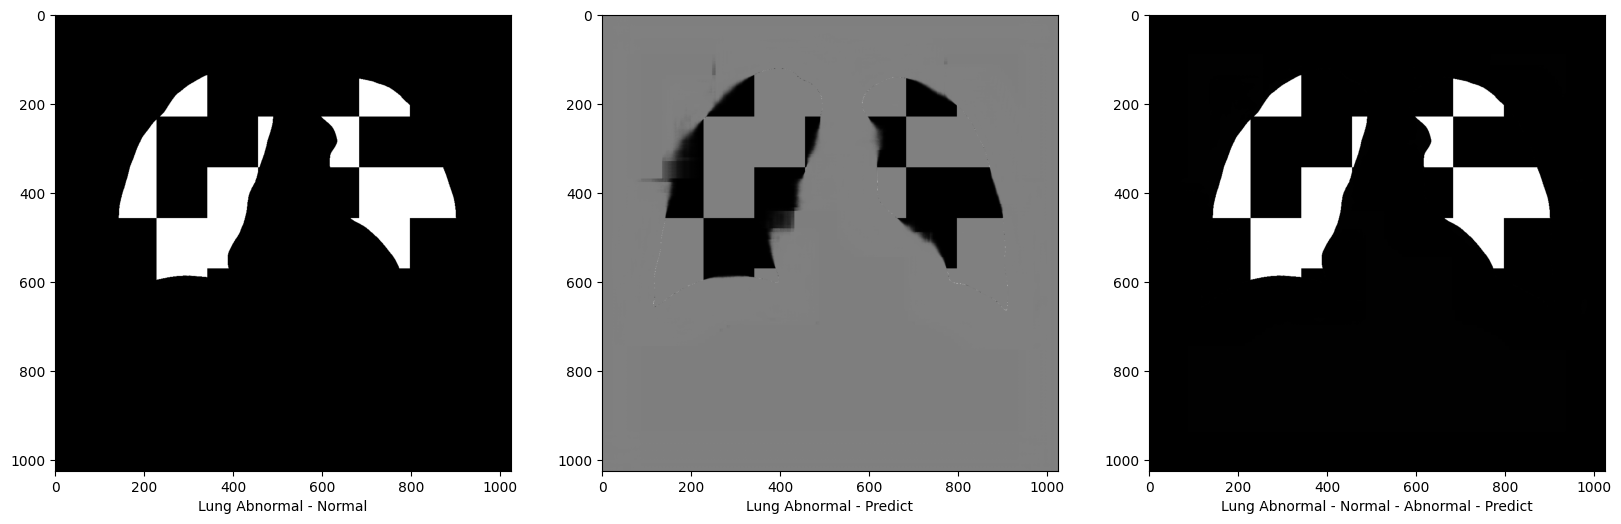

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,450)

## Model mask_c256x256x256x2_f64_64_ep100_relu

In [ ]:
args = {
    'filters' : (16,32),
    'latent_filters':(64,128,256,256),
    'latentDim' : None,
    'model_name' : 'mask_c256x256x256x2_f64_64_ep100_relu',
    'model_dir':'./model',
}
model = DAE_Model(input_shape=(1024,1024,1),**args)

(256, 256, 256)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_c256x256x256x2_f64_64_ep100_relu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_c256x256x256x2_f64_6 (None, 256, 256, 256)     985408    
_________________________________________________________________
decoder_c256x256x256x2_f64_6 (None, 1024, 1024, 1)     1575233   
Total params: 2,560,641
Trainable params: 2,557,633
Non-trainable params: 3,008
_________________________________________________________________


In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 150
bs = 5

In [ ]:
xtrain.shape

(2368, 1024, 1024, 1)

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*8)
model.decay_steps

3784

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/150
473/473 [==============================] - 1225s 3s/step - loss: 0.0571 - lr: 9.9872e-04 - val_loss: 0.0827 - val_lr: 9.9491e-04

Epoch 00001: val_loss improved from inf to 0.08274, saving model to ./model/checkpoint/autoencoder_c256x256x256x2_f64_64_ep100_relu/autoencoder_c256x256x256x2_f64_64_ep100_relu-0001-0.0827.h5
Epoch 2/150
473/473 [==============================] - 1216s 3s/step - loss: 0.0454 - lr: 9.9363e-04 - val_loss: 0.0676 - val_lr: 9.8985e-04

Epoch 00002: val_loss improved from 0.08274 to 0.06755, saving model to ./model/checkpoint/autoencoder_c256x256x256x2_f64_64_ep100_relu/autoencoder_c256x256x256x2_f64_64_ep100_relu-0002-0.0676.h5
Epoch 3/150
473/473 [==============================] - 1218s 3s/step - loss: 0.0435 - lr: 9.8857e-04 - val_loss: 0.2504 - val_lr: 9.8481e-04

Epoch 00003: val_loss did not improve from 0.06755
Epoch 4/150
473/473 [==============================] - 1217s 3s/step - loss: 0.0437 - lr: 9.8354e-04 - val_loss: 0.0595 - val_lr: 9.798

In [ ]:
model.plot_show()

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,450)

## Model mask_c128x128x64x6_f32x64x2_ep150_sigmoid

In [ ]:
args = {
    'filters' : (32,64,64),
    'latent_filters':(64,64,64,64,64),
    'latentDim' : None,
    'model_name' : 'mask_c128x128x64x6_f32x64x2_ep150_sigmoid_maxpl',
    'model_dir':'./model',
}
model = DAE_Model(input_shape=(1024,1024,1),**args)

(128, 128, 64)


In [ ]:
model.autoencoder.summary()

Model: "autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid_maxpl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_mask_c128x128x64x6_f (None, 128, 128, 64)      242304    
_________________________________________________________________
decoder_mask_c128x128x64x6_f (None, 1024, 1024, 1)     279169    
Total params: 521,473
Trainable params: 519,553
Non-trainable params: 1,920
_________________________________________________________________


In [ ]:
# model.autoencoder._name = model.autoencoder.name+'_p2'

In [ ]:
ep = 150
bs = 5

In [ ]:
xtrain.shape

(2368, 1024, 1024, 1)

In [ ]:
train_gen = DataGenerator(xtrain,ytrain,bs)
val_gen = DataGenerator(xval,yval,bs)

In [ ]:
model.set_decay_steps(train_gen.__len__()*8)
model.decay_steps

3784

In [ ]:
model.fit(train_gen,val_gen,ep,bs)

Epoch 1/150
473/473 [==============================] - 211s 426ms/step - loss: 0.0342 - lr: 9.9872e-04 - val_loss: 0.0406 - val_lr: 9.9491e-04

Epoch 00001: val_loss improved from inf to 0.04058, saving model to ./model/checkpoint/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid_maxpl/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid_maxpl-0001-0.0406.h5
Epoch 2/150
473/473 [==============================] - 202s 428ms/step - loss: 0.0158 - lr: 9.9363e-04 - val_loss: 0.4126 - val_lr: 9.8985e-04

Epoch 00002: val_loss did not improve from 0.04058
Epoch 3/150
473/473 [==============================] - 202s 428ms/step - loss: 0.0165 - lr: 9.8857e-04 - val_loss: 0.4769 - val_lr: 9.8481e-04

Epoch 00003: val_loss did not improve from 0.04058
Epoch 4/150
473/473 [==============================] - 202s 428ms/step - loss: 0.0136 - lr: 9.8354e-04 - val_loss: 0.4636 - val_lr: 9.7980e-04

Epoch 00004: val_loss did not improve from 0.04058
Epoch 5/150
473/473 [============================

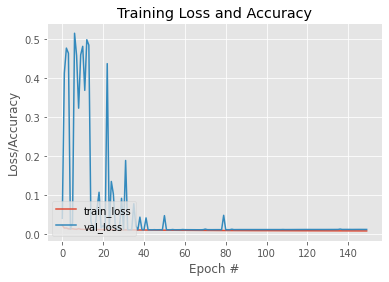

In [ ]:
model.plot_show()

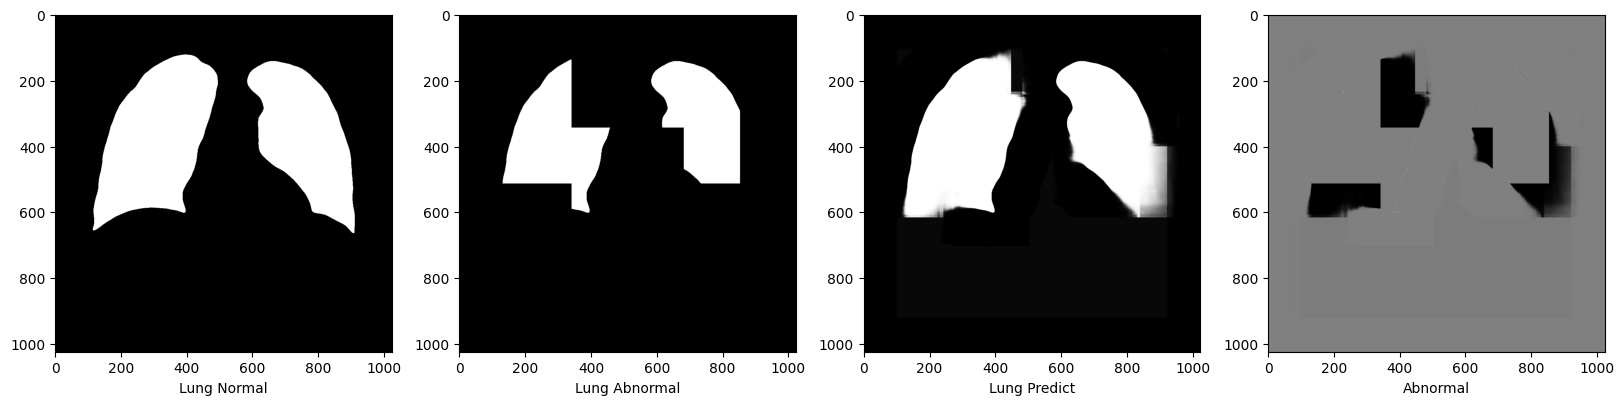

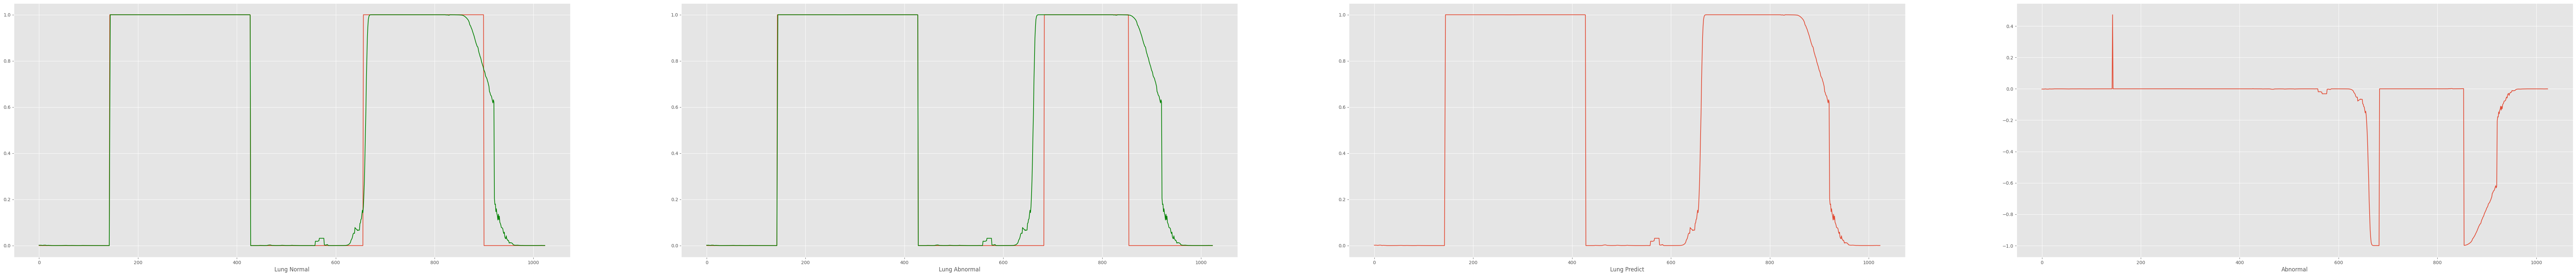

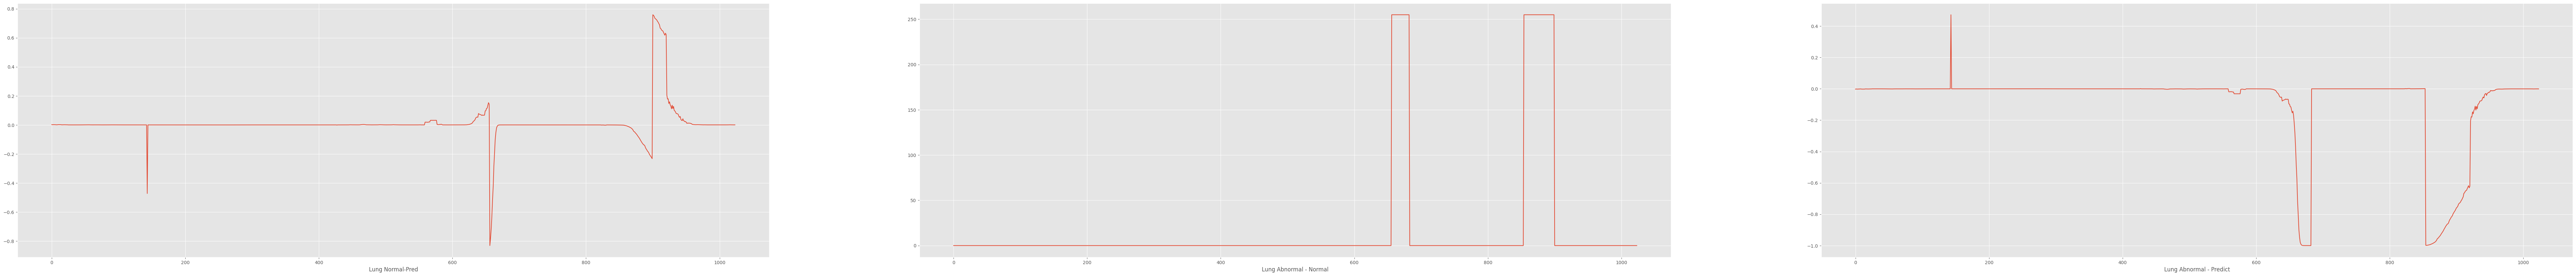

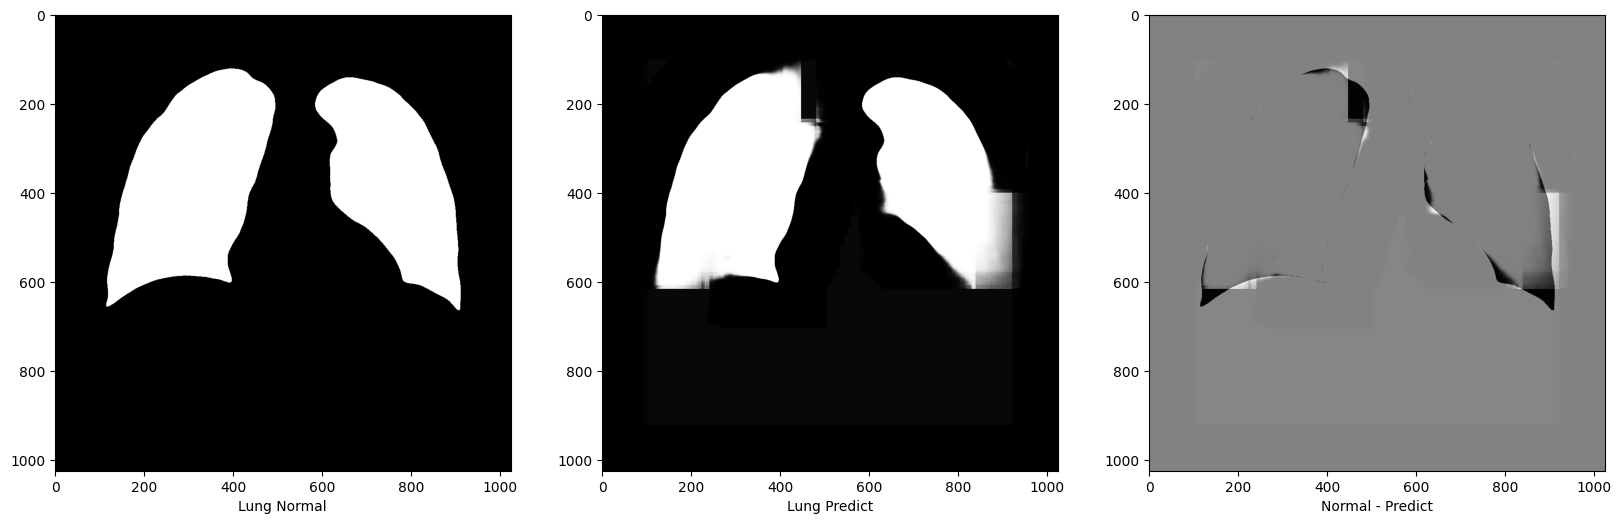

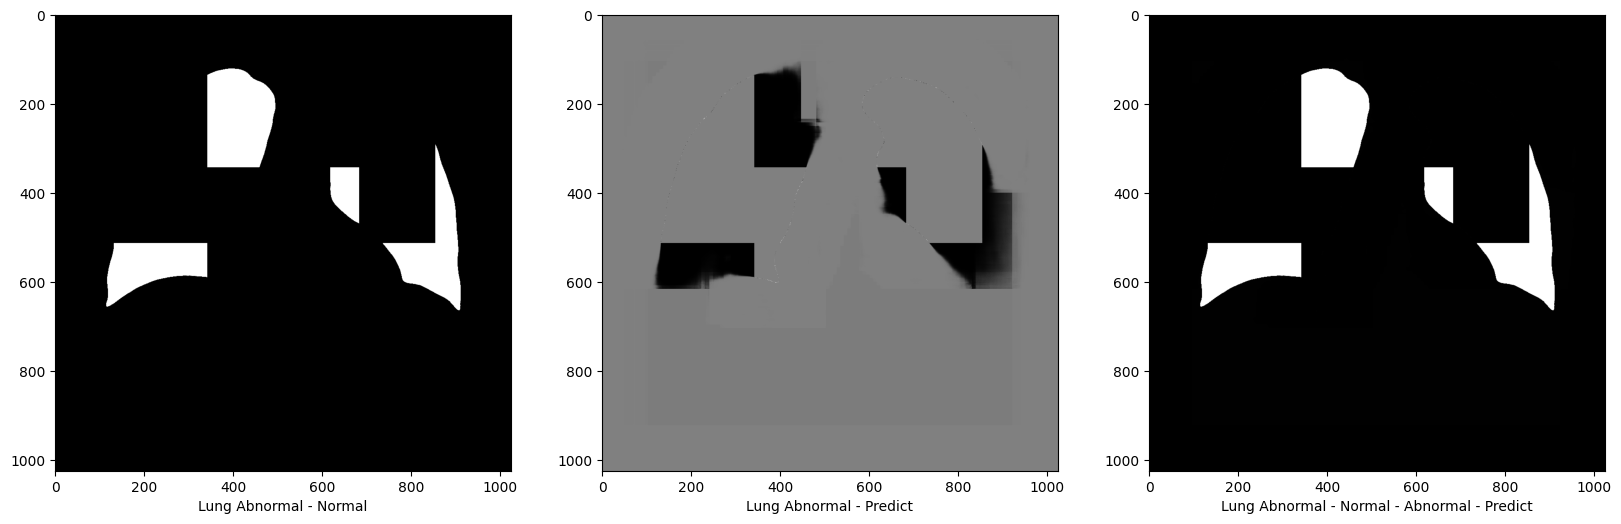

In [ ]:
model.save()
model_view = XABViewer(model.autoencoder,ytest[:10],xtest[:10])
model_view.view_result(3,450)

In [ ]:
model.encoder.summary()

Model: "encoder_mask_c128x128x64x6_f32x64x2_ep150_sigmoid_maxpl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 1024, 32)    320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024, 1024, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024, 32)    128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
leaky_re_lu

## View model

In [ ]:
from keras.models import load_model
import matplotlib.pyplot as plt


In [ ]:
repath = './model/checkpoint/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_relu/autoencoder_mask_c128x128x64x6_f32x64x2_ep150_relu-0045-467.2302.h5'
model = load_model(repath,compile=False)

In [ ]:
model.summary()

Model: "autoencoder_mask_c128x128x64x6_f32x64x2_ep150_relu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
encoder_mask_c128x128x64x6_f (None, 128, 128, 64)      242304    
_________________________________________________________________
decoder_mask_c128x128x64x6_f (None, 1024, 1024, 1)     279169    
Total params: 521,473
Trainable params: 519,553
Non-trainable params: 1,920
_________________________________________________________________


In [ ]:
xgen = model.predict(xtest,batch_size=5)

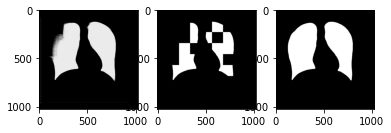

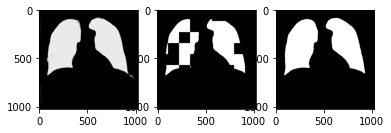

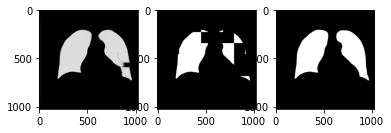

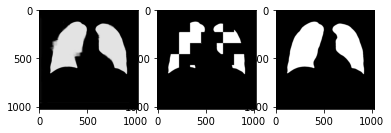

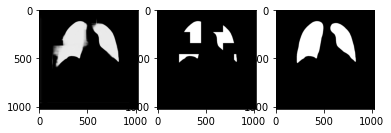

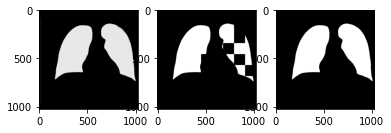

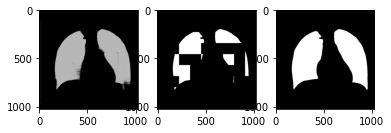

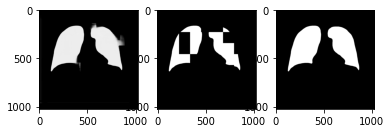

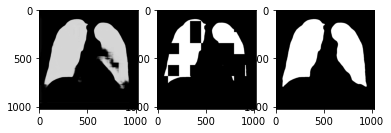

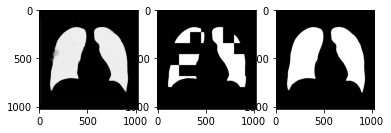

In [ ]:
s = 0
for i in range(10):
  plt.subplot(1,3,1)
  plt.imshow(xgen[i+s,:,:,0],cmap='gray')
  plt.subplot(1,3,2)
  plt.imshow(xtest[i+s,:,:,0],cmap='gray')
  plt.subplot(1,3,3)
  plt.imshow(ytest[i+s,:,:,0],cmap='gray')
  plt.show()

# None stop

In [ ]:
while True:pass

KeyboardInterrupt: ignored